<a href="https://colab.research.google.com/github/joshua-farina/coffee_prices/blob/main/coffe_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Analysis of the coffee dataset found at https://www.kaggle.com/datasets/psycon/daily-coffee-price

Authored by Kais Sheikh and Joshua Farina. 

# Abstract

Our goal is too take a dataset we found on the daily price of coffee and use what skills and tools we have learned to perform some analysis on this time series. We want to see if we can develop a nice well developed model for this time series based on whether it has some patterns or seasonality present as well as, perform some forecasting to see if its possible to predict future values of our time series using prior values from our time series. Finally, we will construct a periodogram to see if we can find some kind of behaviour that repeats after a certain cycle of time.

# Method

First we will begin with some basic analysis on our time series(analyzing the Autocorrelation Function(ACF) graph, the Partial Autocorrelation Function(PACF) graph as well as the Cross Correlation Function (CCF) graphs), but first we will have to break up our dataset into pieces because what we have here is a multivariate(multi variable) time series and most of the methods we've learned in class operate only on univariate(single variable) time series so all we do is create a time series for each variable. To get a better idea on the behaviour of our dataset to decide if we need to apply some transformations or alter our dataset in anyways to fit our data into a well designed Autoregressive Intergrated Moving Average (ARIMA) model or a Seasonal ARIMA(SARIMA) model based on if we find some seasonality behaviour. Afterwards we will wrap up by performing some forecasting to see if we can derive 

In [ ]:
install.packages("astsa")
install.packages("forecast")
install.packages("fma")

install.packages("TSA")

install.packages('xts')
install.packages('zoo')
install.packages("PerformanceAnalytics")
install.packages("dynlm")
install.packages("fGarch")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘Rcpp’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘leaps’, ‘locfit’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘p

In [ ]:
library(astsa)
library(fma)
library(forecast)
library(zoo)
library(xts)
library(TSA)
library(PerformanceAnalytics)
library(lubridate)
library(repr)
library(dynlm)
library(fGarch)

Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:astsa’:

    gas



Attaching package: ‘fma’


The following objects are masked from ‘package:astsa’:

    chicken, sales



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Registered S3 methods overwritten by 'TSA':
  method       from    
  fitted.Arima forecast
  plot.Arima   forecast


Attaching package: ‘TSA’


The following objects are masked from ‘package:stats’:

    acf, arima


The following object is masked from ‘package:utils’:

    tar



Attaching package: ‘PerformanceAnalytics’


The following objects are masked from ‘package:TSA’:

    kurtosis, skewness


The following object is masked from ‘package:graphics’:

    legend


Loading required package: timechange

Warning message in system("timedate

In [ ]:
data <- read.csv(file = 'https://drive.google.com/uc?export=download&id=1xTXESuCk0FEqOBalb2W91ccDc0XAsxHU',   ) #imports coffee data (may have to reimport csv file everytime opening Colab)

In [ ]:
# Compute AR roots
arroots <- function(object)
{
  if(!("Arima" %in% class(object)) &
     !("ar" %in% class(object)))
    stop("object must be of class Arima or ar")
  if("Arima" %in% class(object))
    parvec <- object$model$phi
  else
    parvec <- object$ar
  if(length(parvec) > 0)
  {
    last.nonzero <- max(which(abs(parvec) > 1e-08))
    if (last.nonzero > 0)
      return(structure(list(
        roots=polyroot(c(1,-parvec[1:last.nonzero])),
        type="AR"),
        class='armaroots'))
  }
  return(structure(list(roots=numeric(0), type="AR"),
                   class='armaroots'))
}

# Compute MA roots
maroots <- function(object)
{
  if(!("Arima" %in% class(object)))
    stop("object must be of class Arima")
  parvec <- object$model$theta
  if(length(parvec) > 0)
  {
    last.nonzero <- max(which(abs(parvec) > 1e-08))
    if (last.nonzero > 0)
      return(structure(list(
        roots=polyroot(c(1,parvec[1:last.nonzero])),
        type="MA"),
        class='armaroots'))
  }
  return(structure(list(roots=numeric(0), type="MA"),
                   class='armaroots'))
}

plot.armaroots <- function(x, xlab="Real", ylab="Imaginary",
                           main=paste("Inverse roots of", x$type,
                                      "characteristic polynomial"),
                           ...)
{
  oldpar <- par(pty='s')
  on.exit(par(oldpar))
  plot(c(-1,1), c(-1,1), xlab=xlab, ylab=ylab,
       type="n", bty="n", xaxt="n", yaxt="n", main=main, ...)
  axis(1, at=c(-1,0,1), line=0.5, tck=-0.025)
  axis(2, at=c(-1,0,1), label=c("-i","0","i"),
       line=0.5, tck=-0.025)
  circx <- seq(-1,1,l=501)
  circy <- sqrt(1-circx^2)
  lines(c(circx,circx), c(circy,-circy), col='gray')
  lines(c(-2,2), c(0,0), col='gray')
  lines(c(0,0), c(-2,2), col='gray')
  if(length(x$roots) > 0)
  {
    inside <- abs(x$roots) > 1
    points(1/x$roots[inside], pch=19, col='black')
    if(sum(!inside) > 0)
      points(1/x$roots[!inside], pch=19, col='red')
  }
}


We break up our dataset into several different time series. We also derive a time series for daily returns using a common formula -- the difference between the opening and closing prices as a percentage of the opening price. 

In [ ]:
open.ts <- as.ts(data$Open) #convert Multivariate Time Series into a Univariate TS
high.ts <- as.ts(data$High) 
low.ts <- as.ts(data$Low)
close.ts <- as.ts(data$Close)
volume.ts <- as.ts(data$Volume)
data$daily.return = (close.ts - open.ts)/open.ts
daily.return= data$daily.return


# Standard plots of the time series for each variable. 

The variable closest to stationarity is the daily return calculation. Daily return is a good marker of profitability, so a lot of our analysis will focus on that. However, we will continue to monitor all of our variables.  

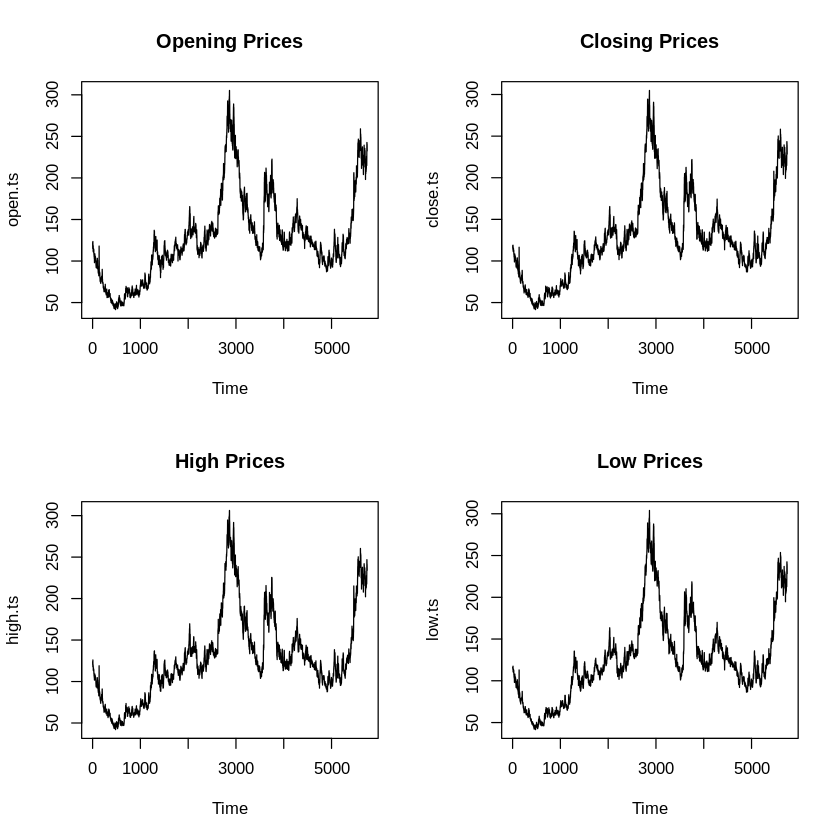

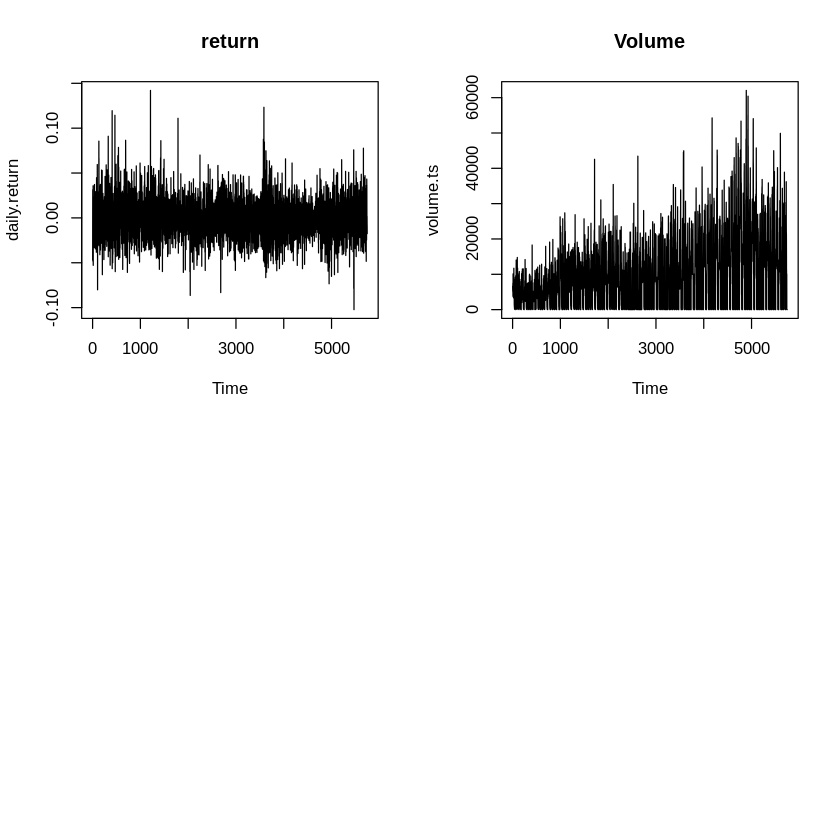

In [ ]:
par(mfrow=c(2,2))
plot(open.ts, main = "Opening Prices")
plot(close.ts, main = "Closing Prices")
plot(high.ts, main = "High Prices")
plot(low.ts, main = "Low Prices")
plot(daily.return, main = "return")

plot(volume.ts, main = "Volume")


# Calculate the growth rate (suffixed as "gr") where possible. 
For the other variables, we'll try and manipulate them into stationarity with some transformations. 

Here we run into a problem with the volume variable. The variance of the volume variable appears to grow over time. We would typically attempt to remediate this with the log function, but the data has days with volume of zero (an inf value by the log function).  

We'll rerun our time series plots alongside the ACFs to get a sense of whether these steps are working. 



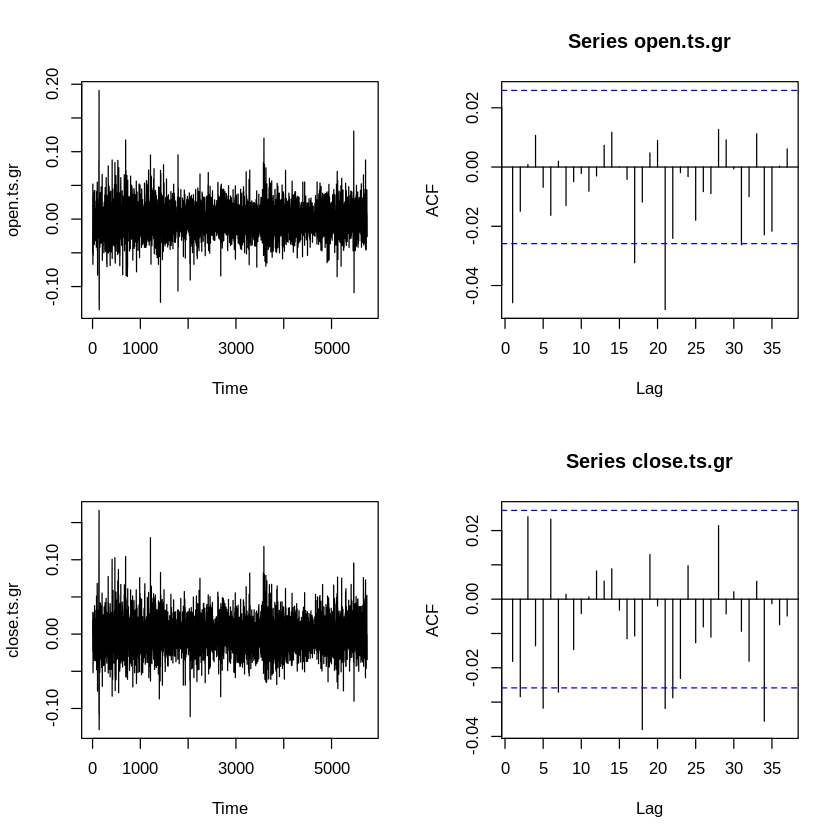

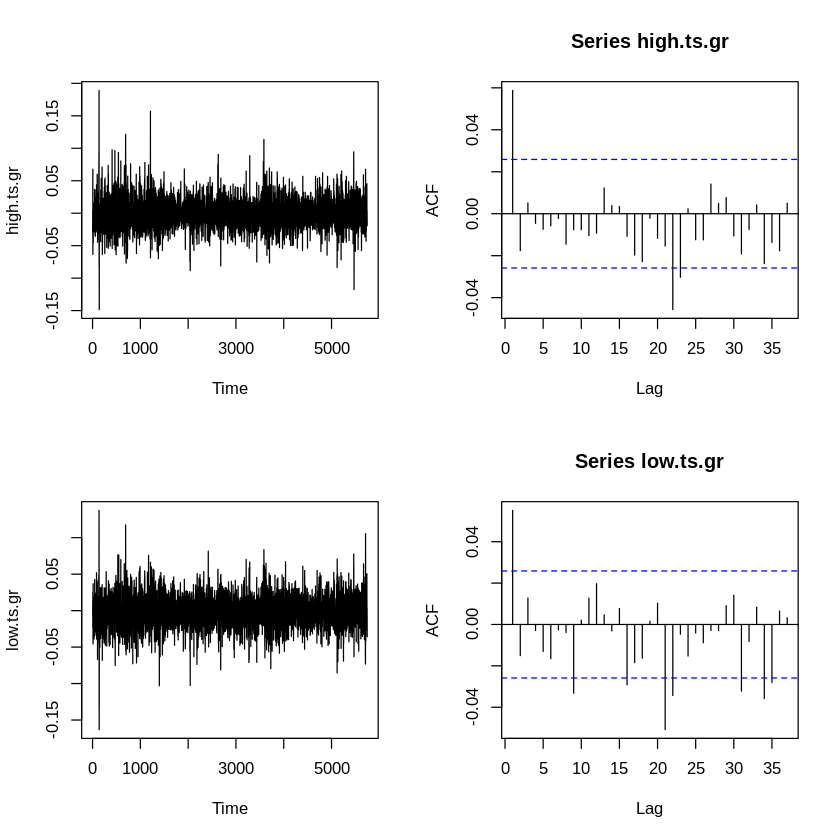

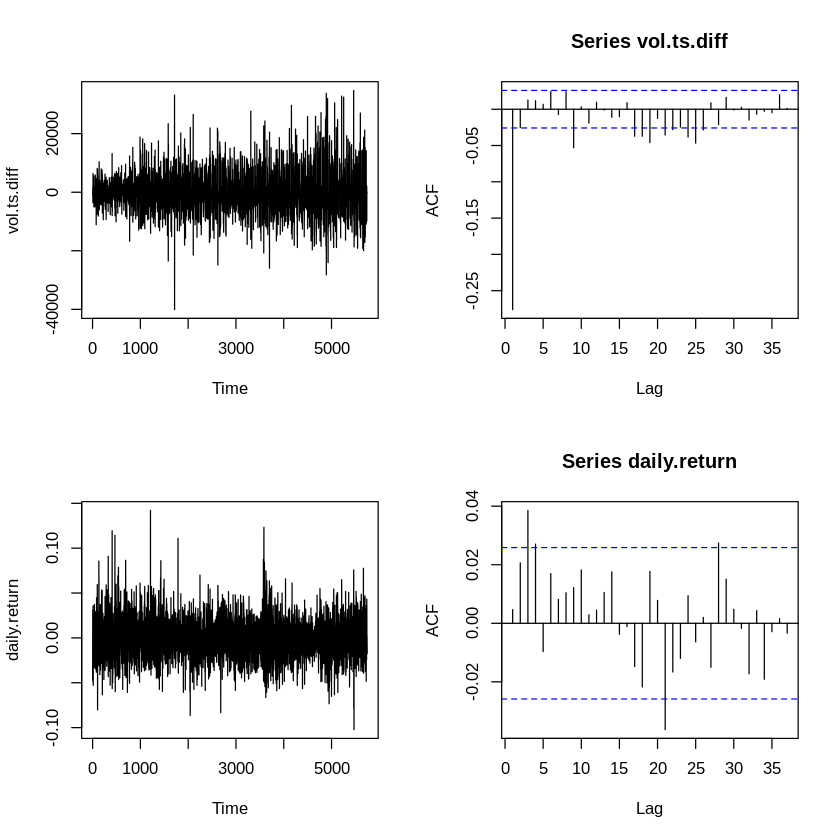

In [ ]:
open.ts.gr = diff(log(open.ts))
close.ts.gr = diff(log(close.ts))
high.ts.gr = diff(log(high.ts))
low.ts.gr = diff(log(low.ts))
vol.ts.diff = diff(volume.ts)
daily.return = (close.ts-open.ts)/open.ts
par(mfrow=c(2,2))
plot(open.ts.gr) 
acf(open.ts.gr) 
plot(close.ts.gr)
acf(close.ts.gr)
plot(high.ts.gr) 
acf(high.ts.gr) 
plot(low.ts.gr) 
acf(low.ts.gr) 
plot(vol.ts.diff)
acf(vol.ts.diff)
plot(daily.return)
acf(daily.return)

Something that we observed is that there are a number of observations in the dataset with no trading volume. Those observations disrupted some of our transformations on the volume time series. It also cast suspicion on the values of the covariates at the given points in time. 

The following boxplots were meant to identify any seasonality or cyclic behavior that didn't stand out in the ACFs. We broke up the data into some discrete variables to see whether we parse out any other patters. 

Although we did discover that there are a number of "Sundays" in the dataset with anomalous values, we didn't pick out any clear trends otherwise. 



In [ ]:
data$wday = wday(data$Date, label=TRUE)
data$month = month(data$Date, label=TRUE)
data$mday = mday(data$Date)
data$yday = yday(data$Date)

sum(data$wday=="Sun"|data$wday=="Sat")

[1] 41

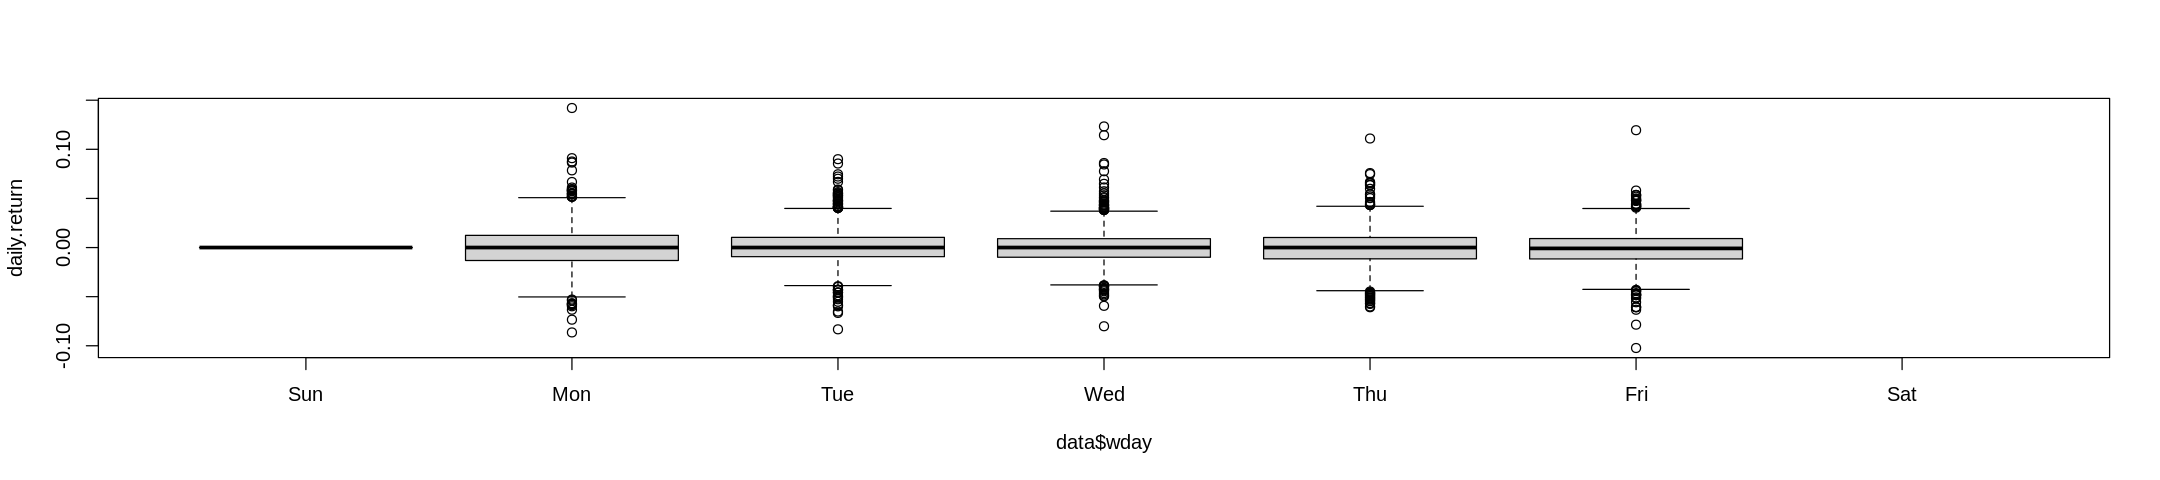

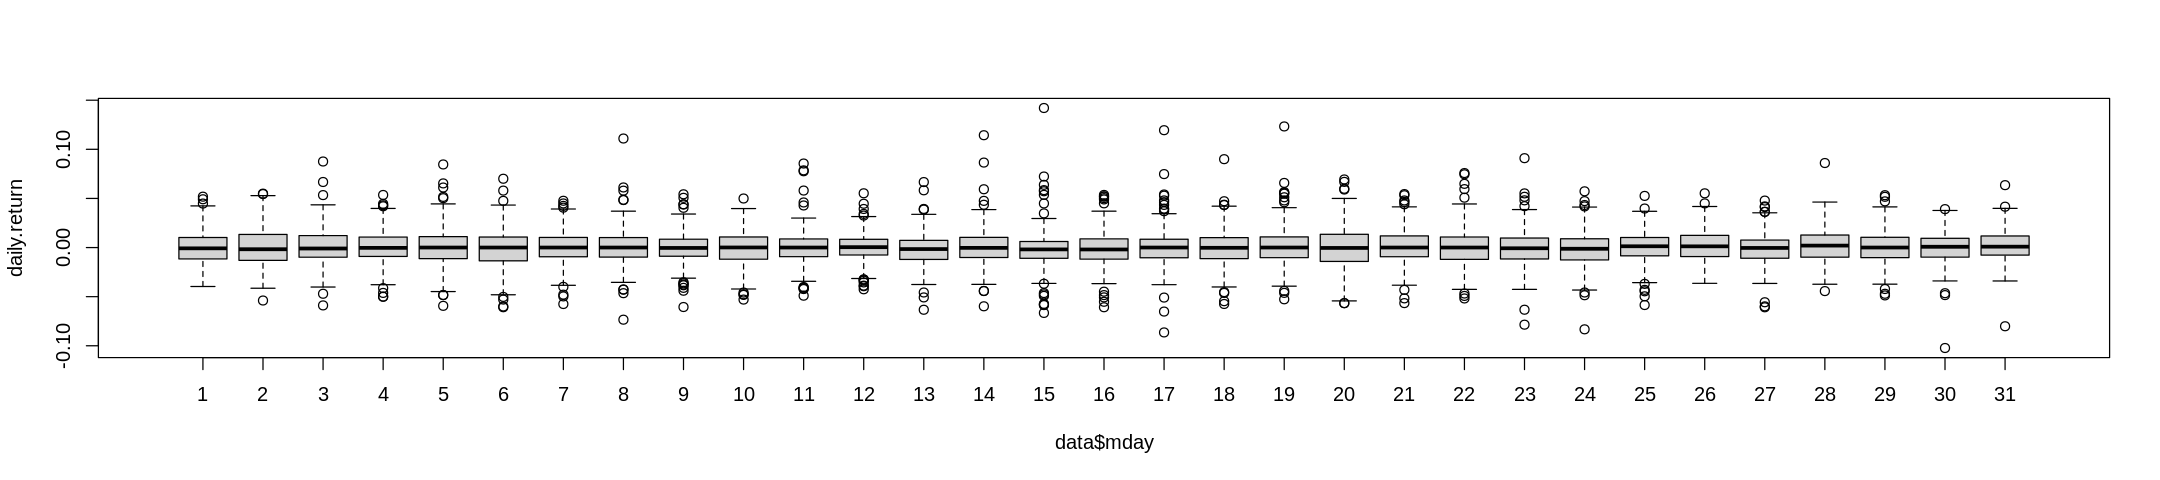

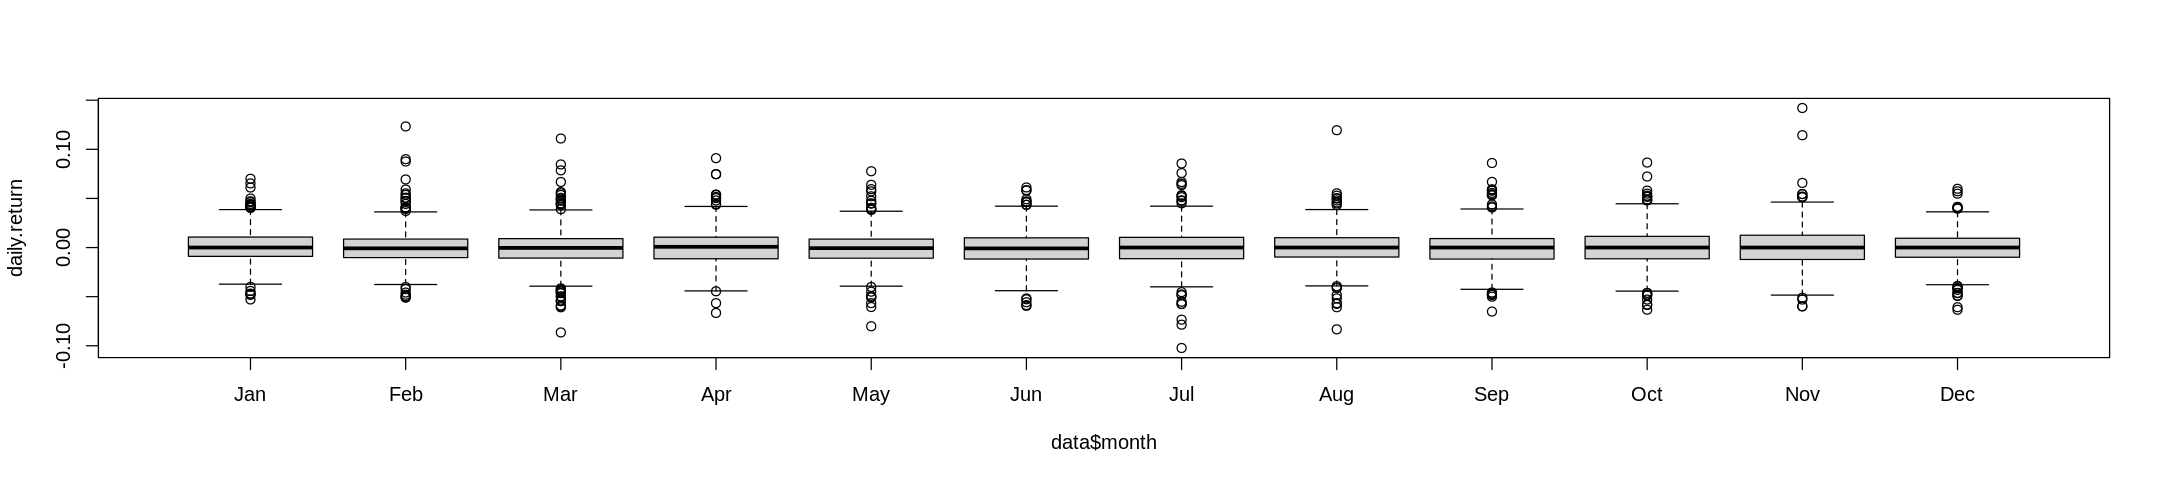

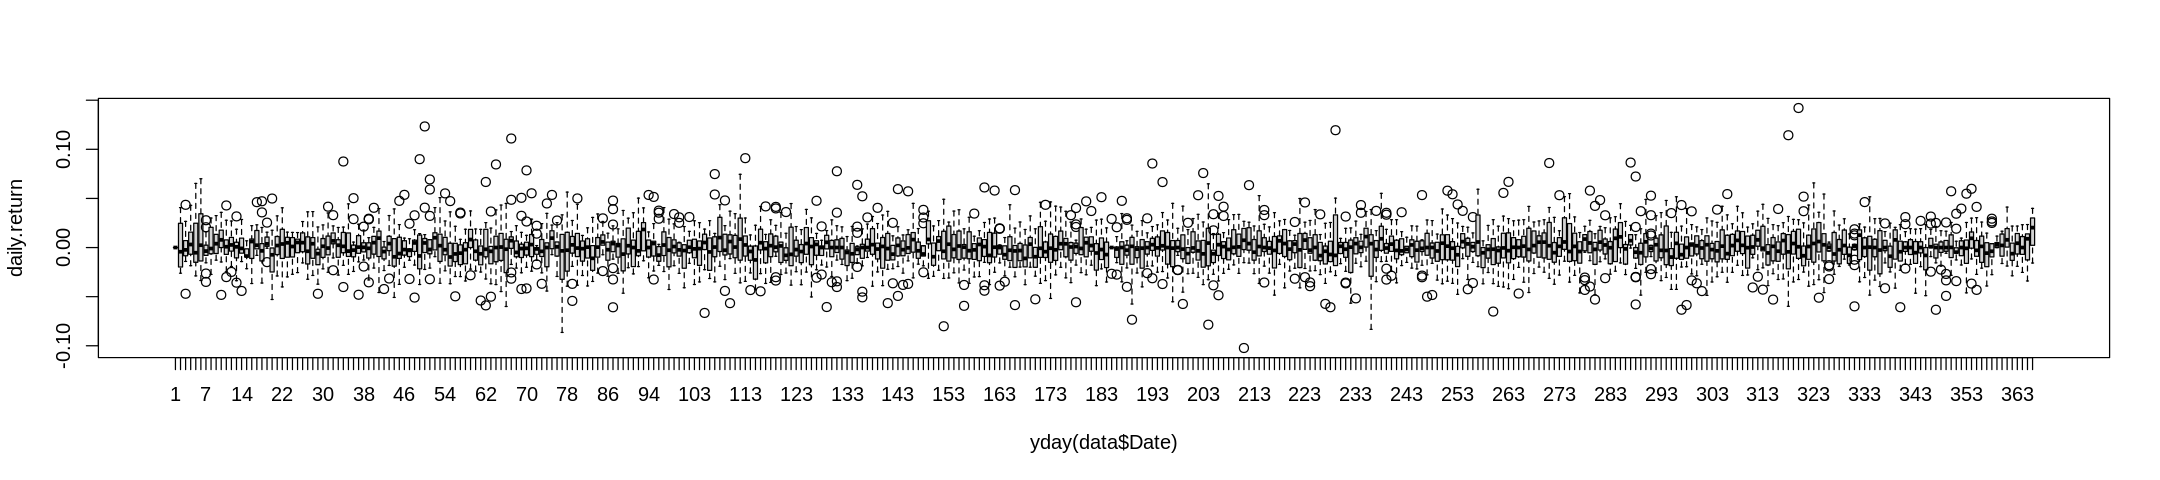

In [ ]:

options(repr.plot.width=18, repr.plot.height=4)
boxplot(daily.return~data$wday)
boxplot(daily.return~data$mday)
boxplot(daily.return~data$month)
boxplot(daily.return~yday(data$Date))




Next, we looked at the cross correlations between the different graphs. The last five plots are especially important as we will trying to use the daily return calculation to find oppertunistic points in time. 

Daily return is calculated as the following:

$\frac{Close - Open}{Open}$


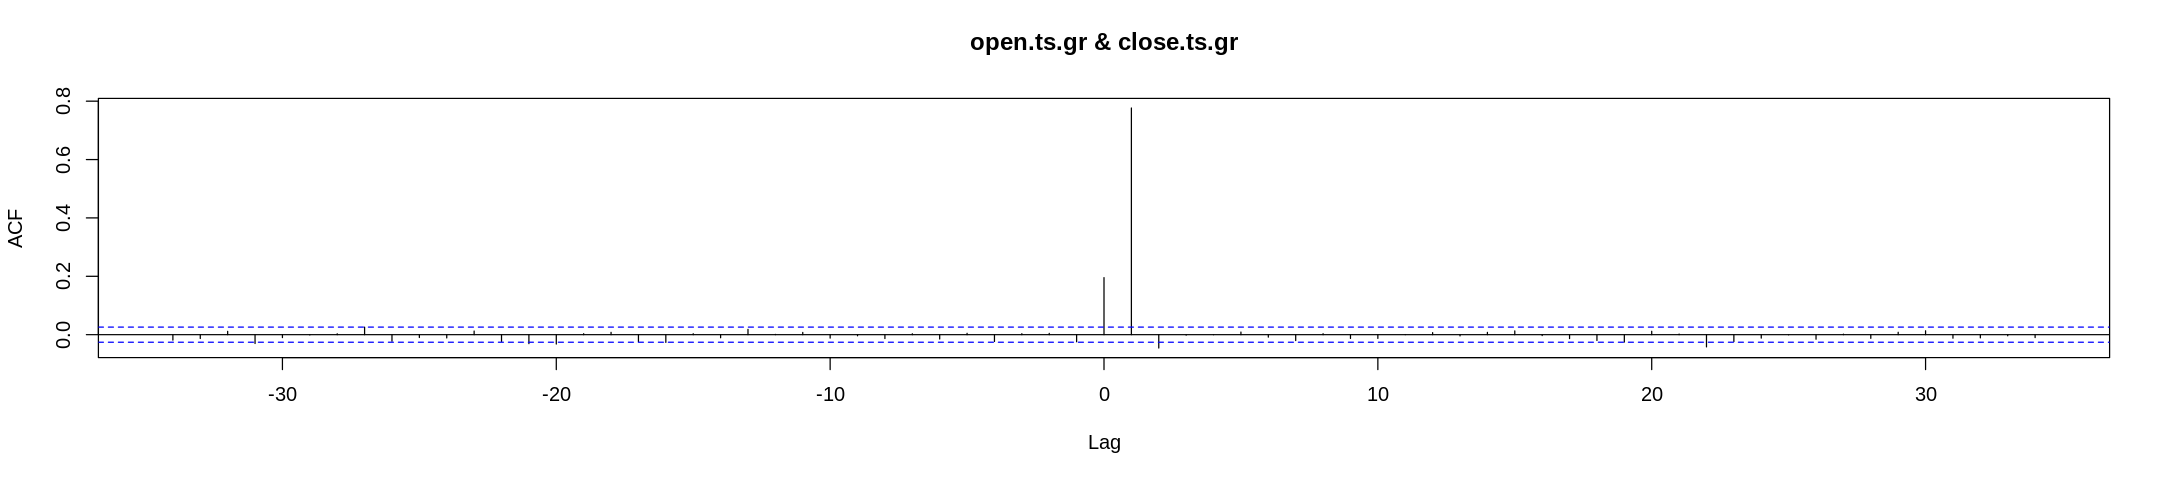

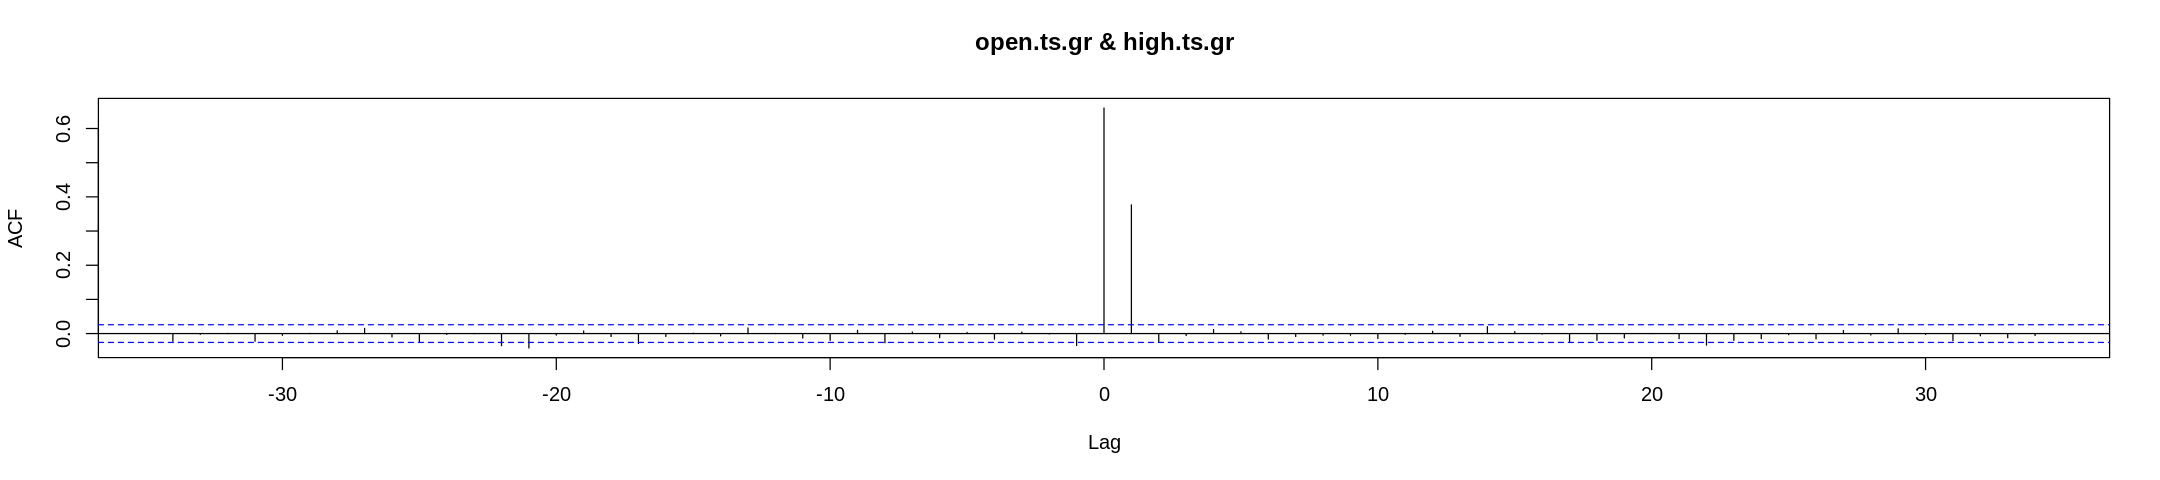

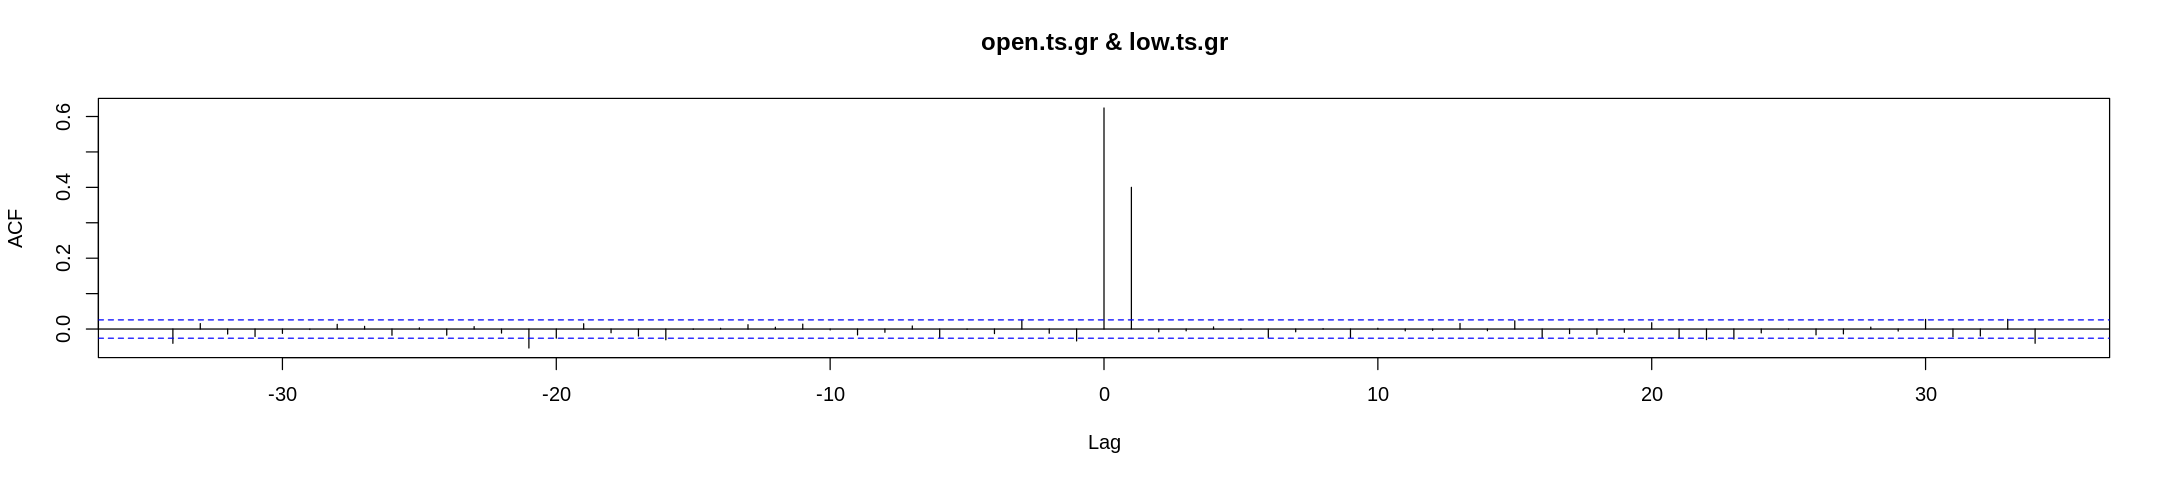

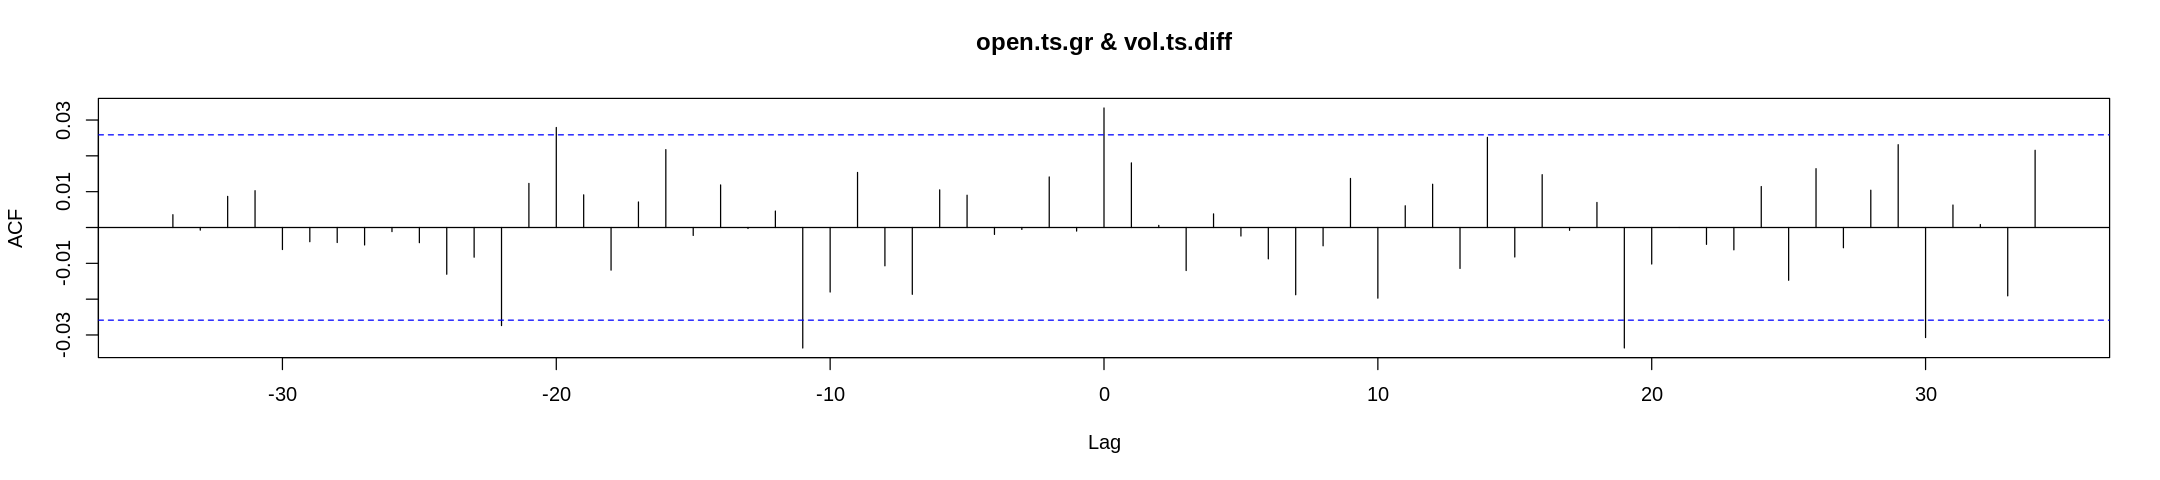

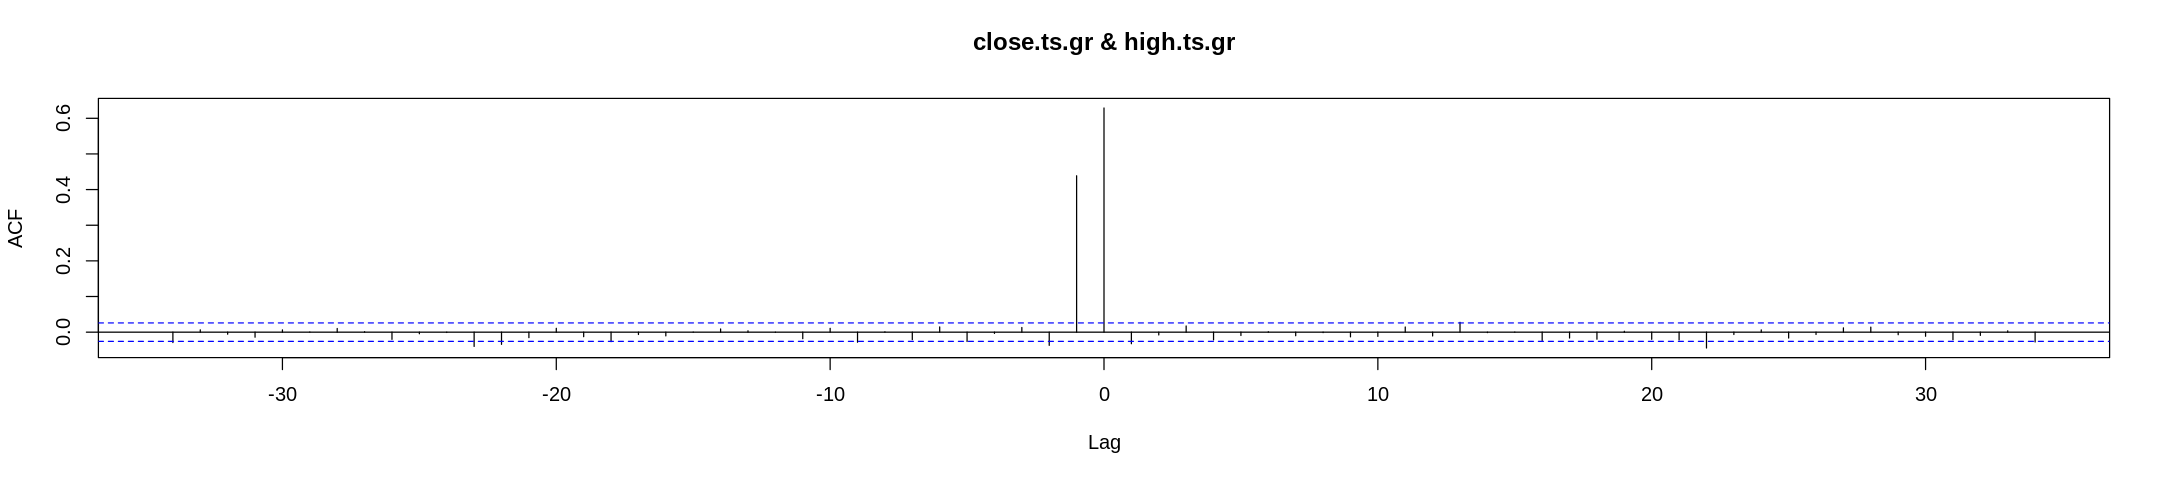

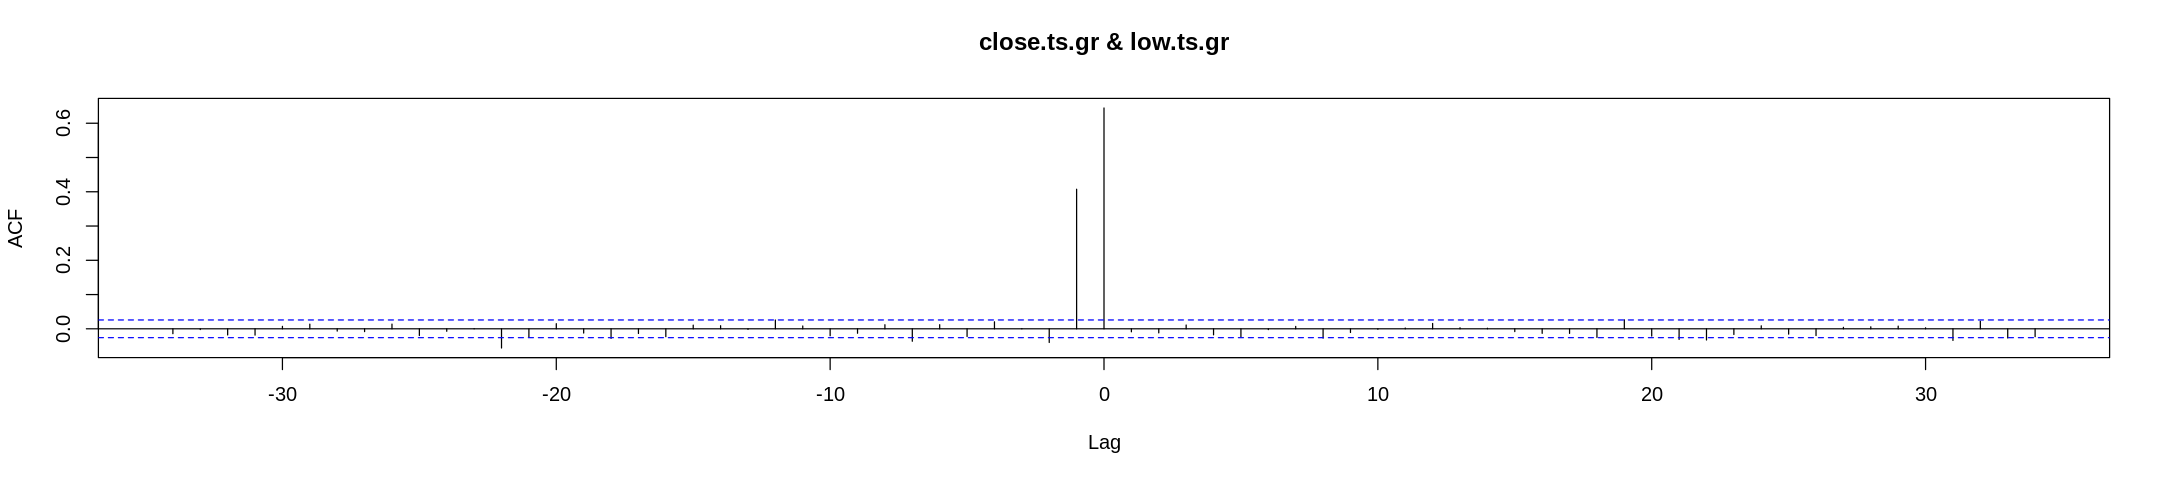

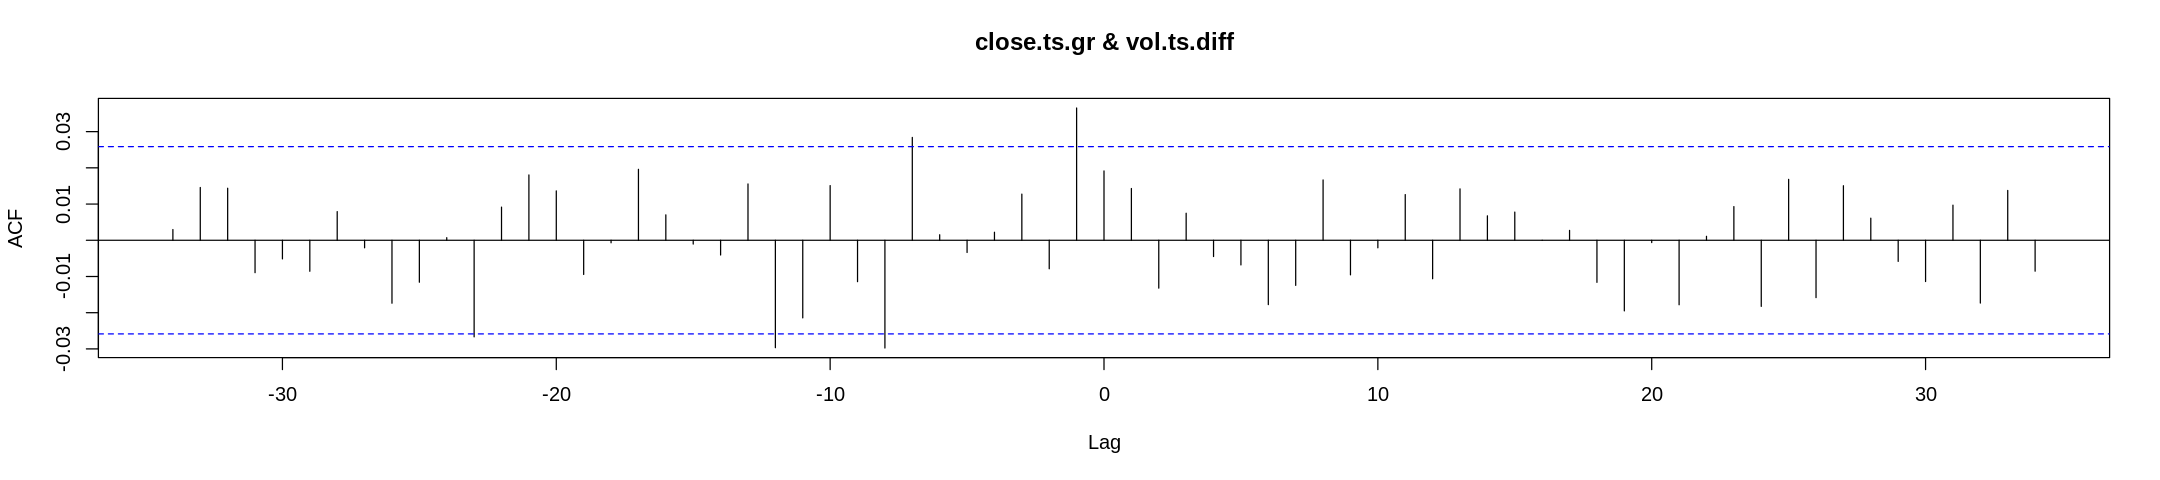

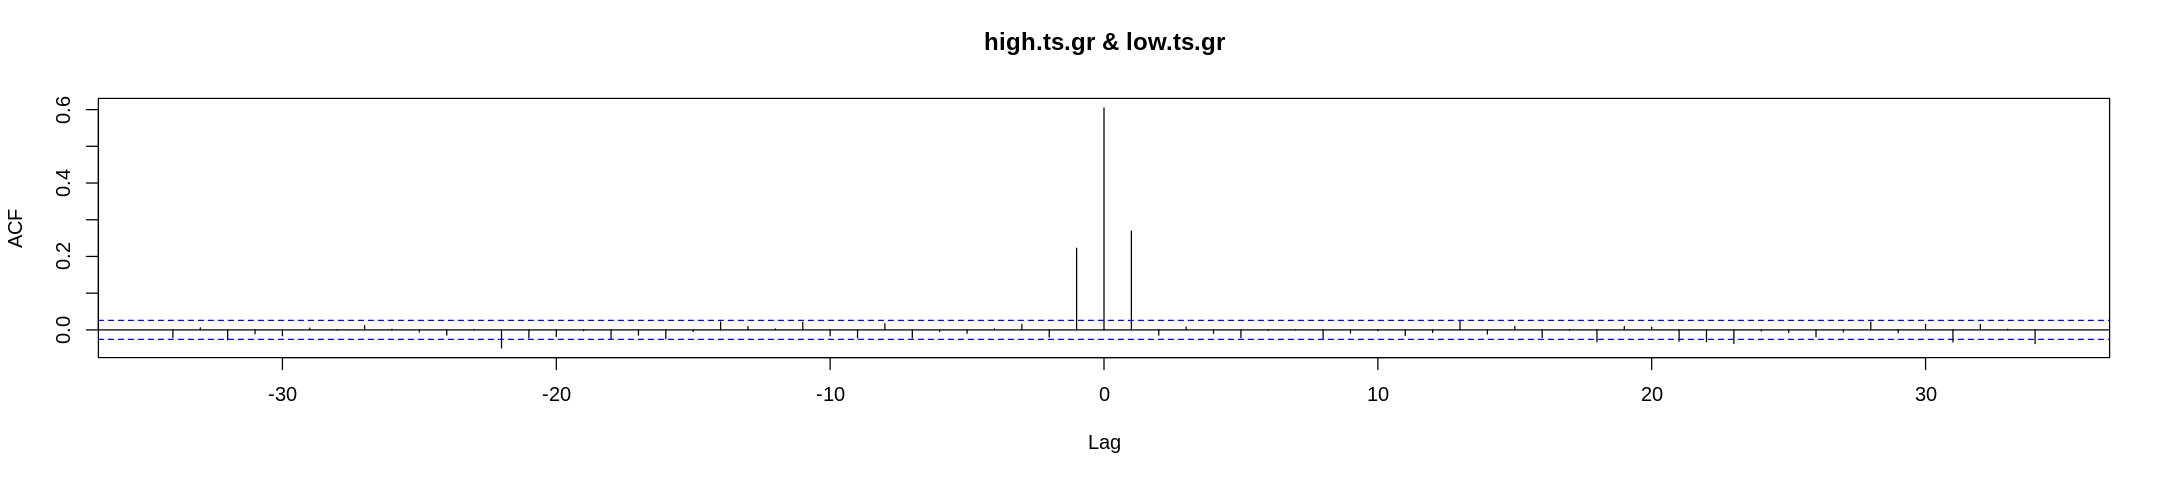

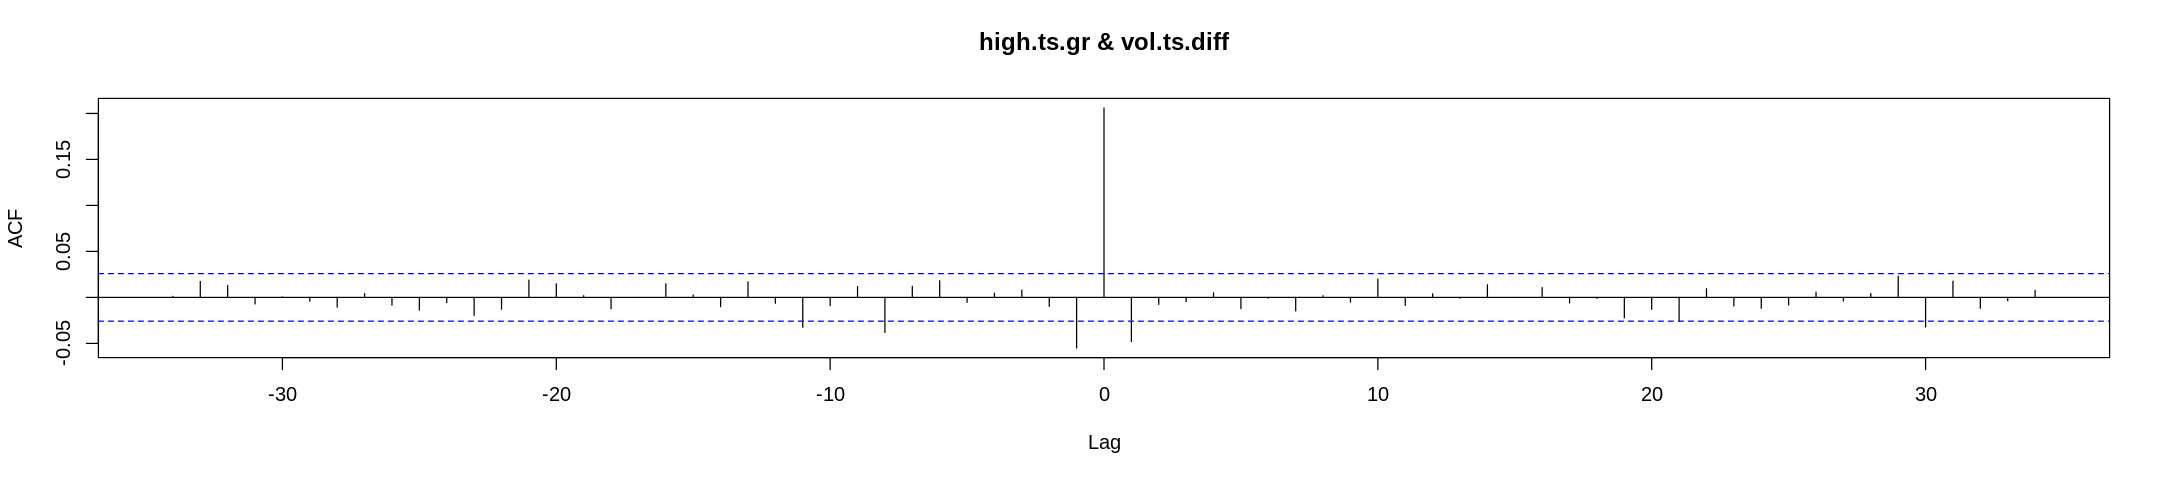

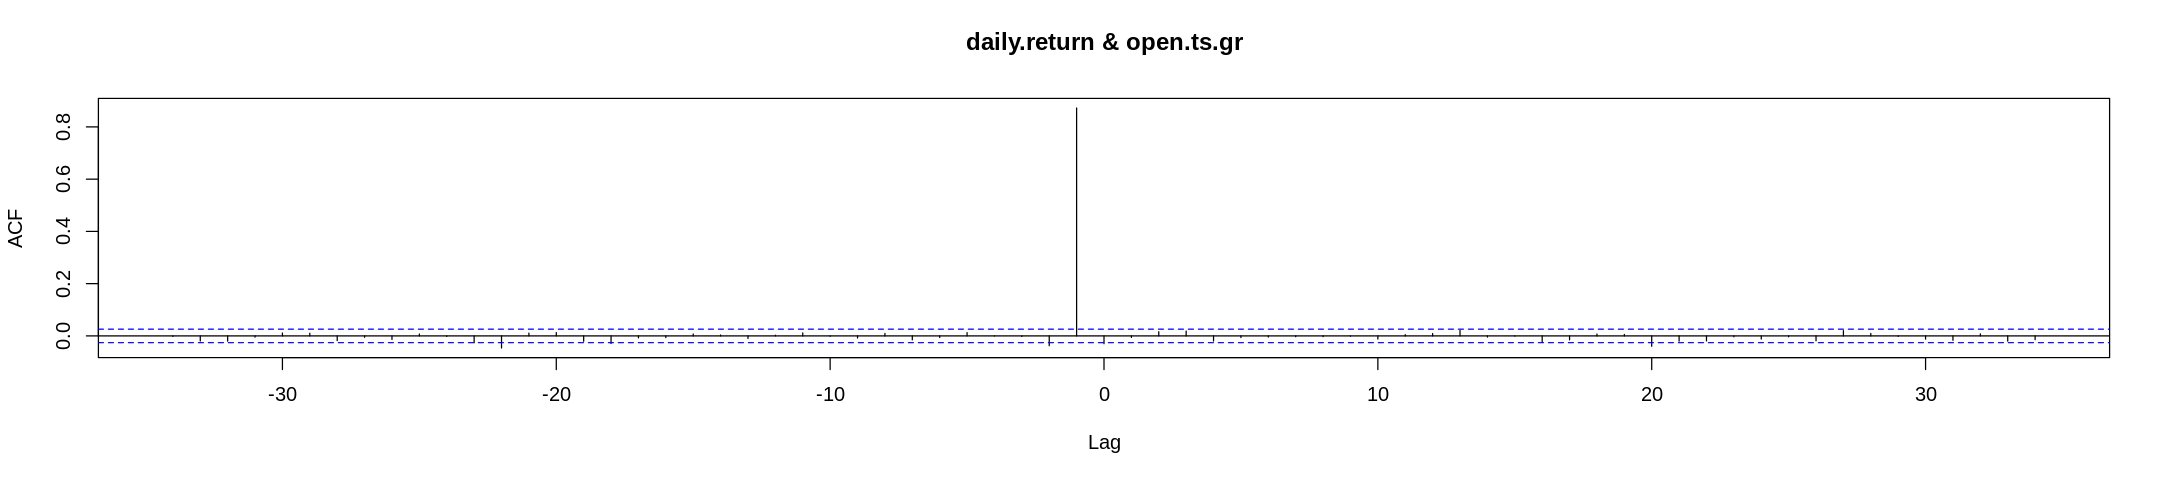

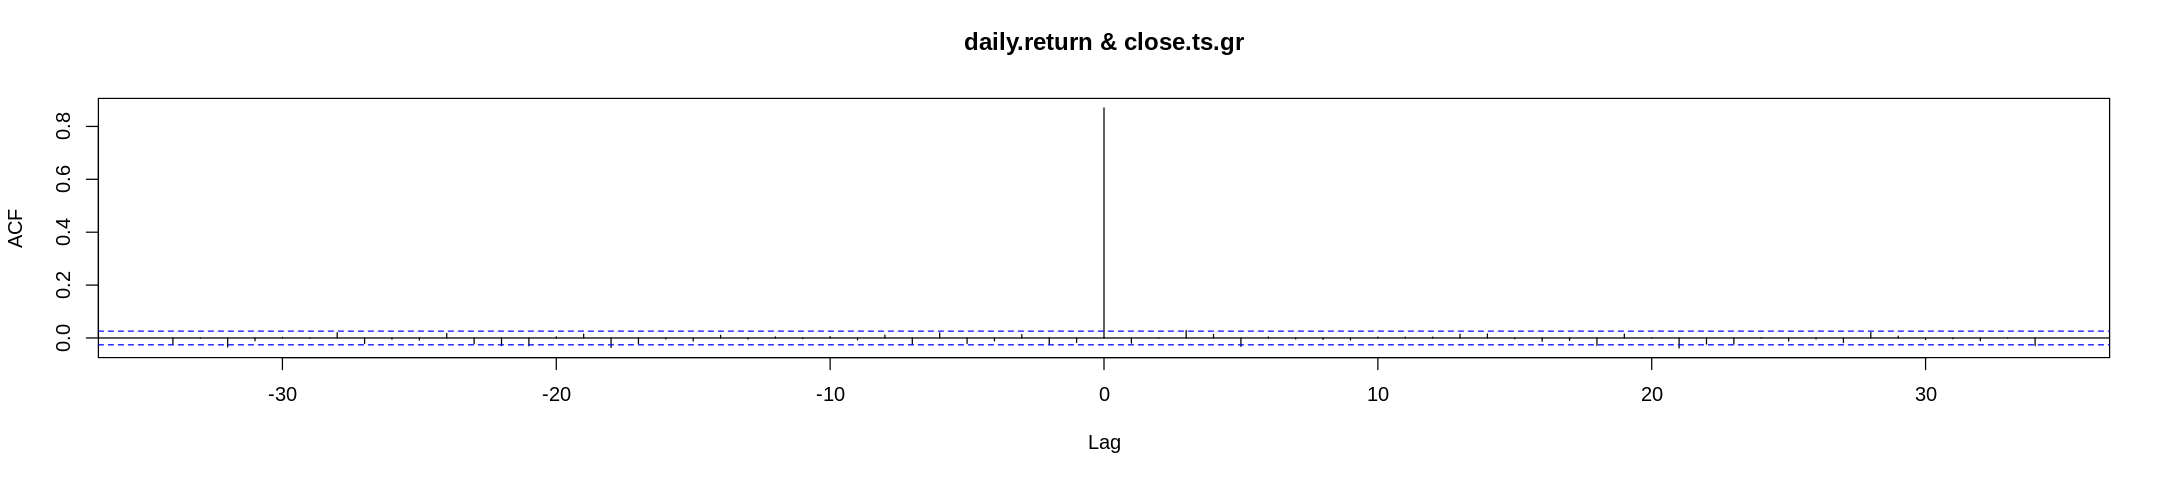

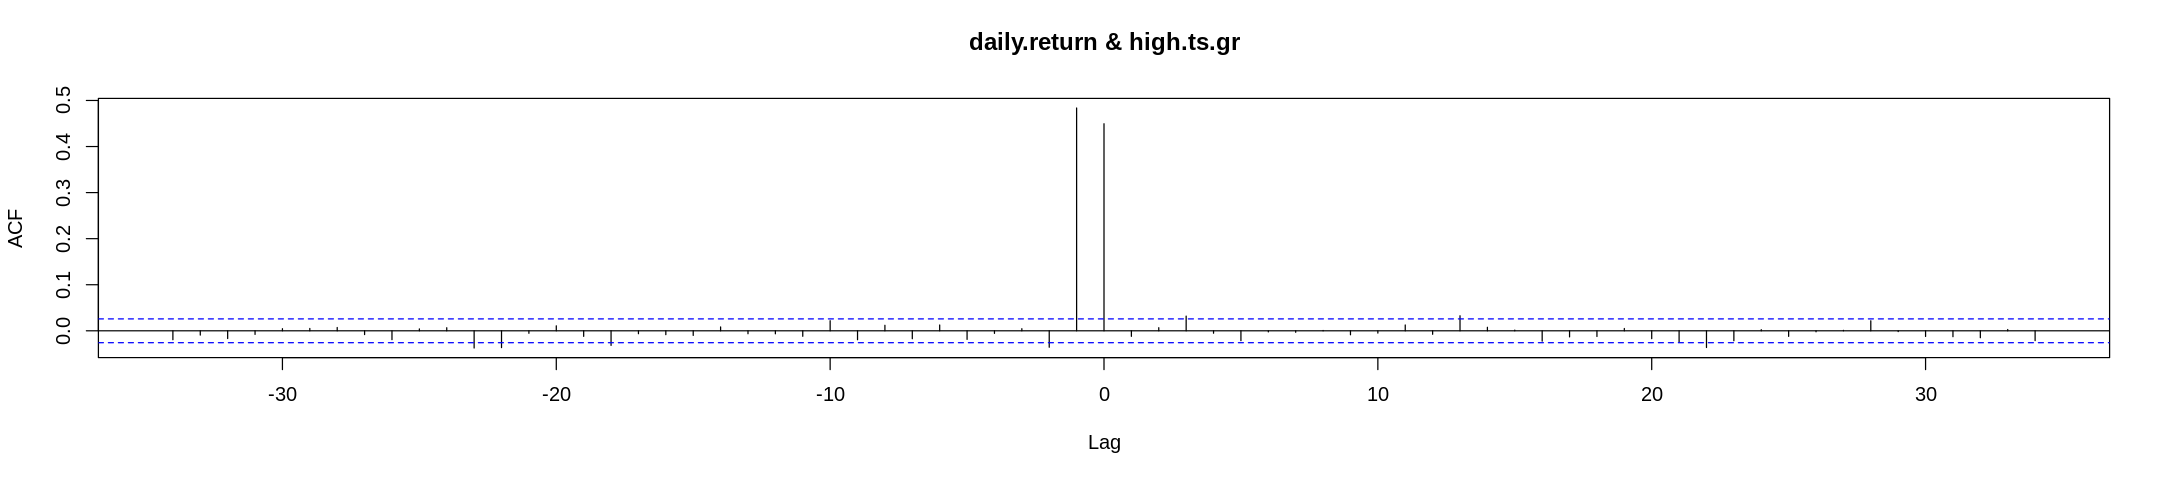

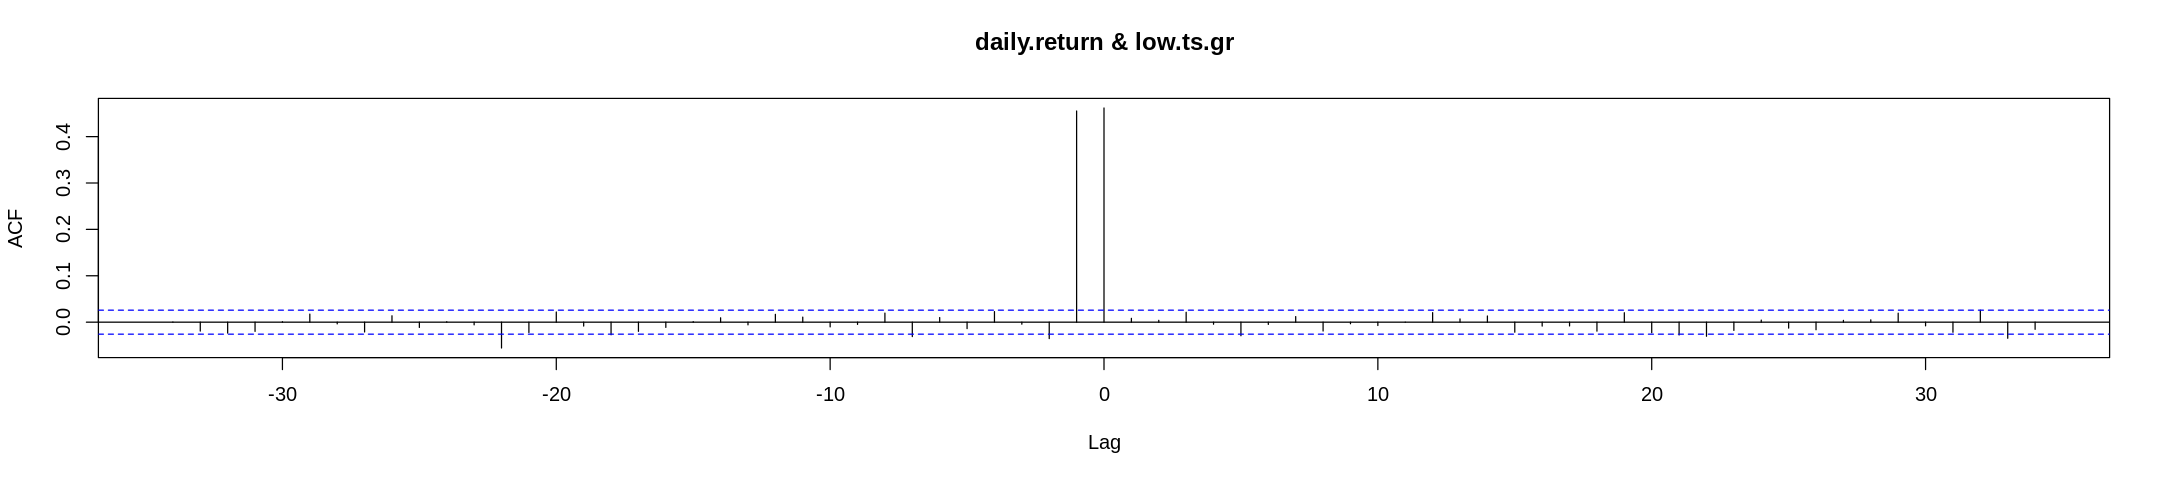

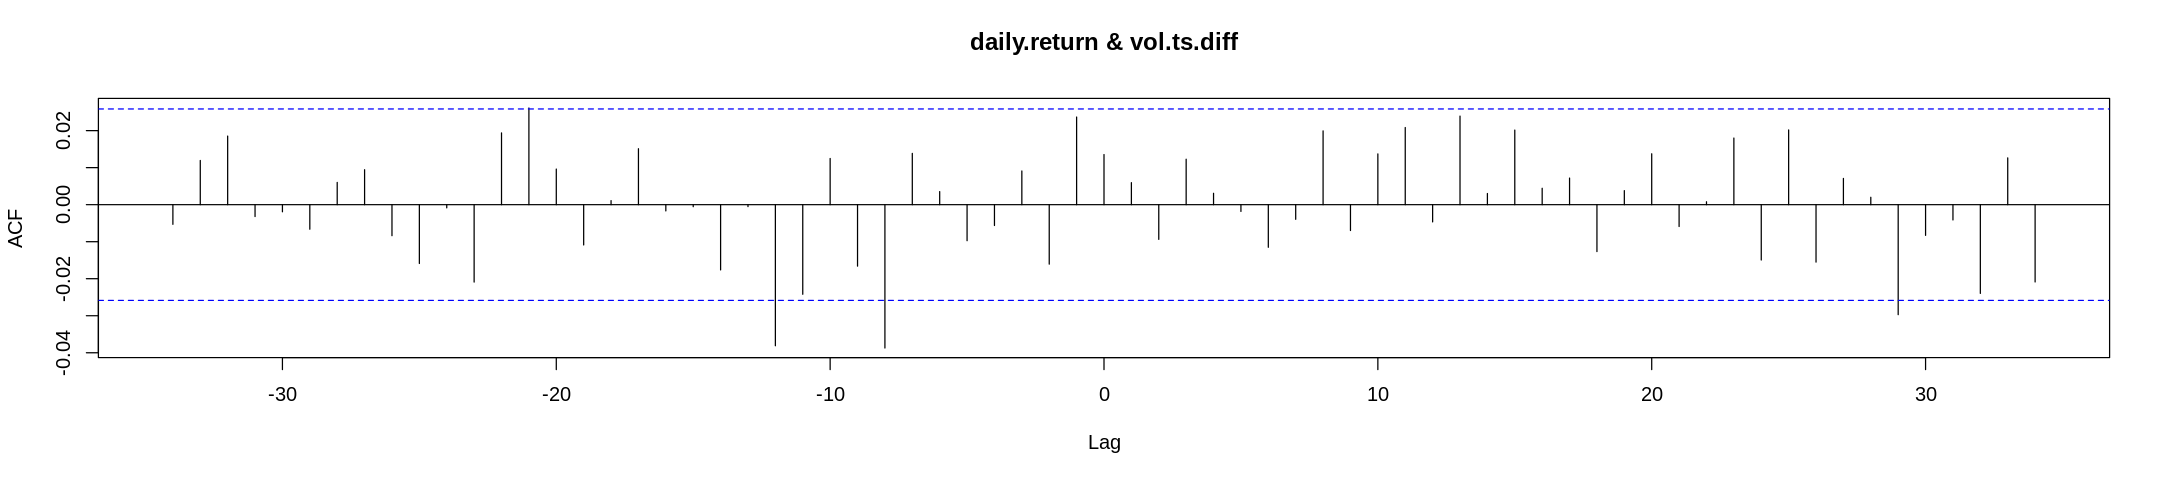

In [ ]:
ccf(open.ts.gr, close.ts.gr) #CCF Between Open and Close
ccf(open.ts.gr, high.ts.gr) #CCF Between Open and High
ccf(open.ts.gr, low.ts.gr) #CCF Between Open and Low
ccf(open.ts.gr, vol.ts.diff) #CCF Between Open and Volume
ccf(close.ts.gr, high.ts.gr) #CCF Between Close and High
ccf(close.ts.gr, low.ts.gr) #CCF Between Close and Low
ccf(close.ts.gr, vol.ts.diff) #CCF Between Close and Volume
ccf(high.ts.gr, low.ts.gr) #CCF Between High and Low
ccf(high.ts.gr, vol.ts.diff) #CCF Between High and volume
ccf(daily.return, open.ts.gr) #CCF Between Daily Returns vs Open
ccf(daily.return, close.ts.gr) #CCF Between Daily Returns vs Close
ccf(daily.return, high.ts.gr) #CCF Between Daily Returns vs High
ccf(daily.return, low.ts.gr) #CCF Between Daily Returns vs Low
ccf(daily.return, vol.ts.diff) #CCF Between Daily Returns vs Volume

Below we run a few regressions to verify our understanding of the CCF plots. We pick out 

$open.ts.gr = B(daily.return) +\epsilon$  and $open.ts.gr = daily.return +B(daily.return) +\epsilon$  

and note that the cofficients are significant and broadly in line with the ccf plots. 

In [ ]:
summary(dynlm(open.ts.gr~L(daily.return, 1)))
summary(dynlm(high.ts.gr~L(daily.return, 1) + daily.return))


Time series regression with "ts" data:
Start = 2, End = 5746

Call:
dynlm(formula = open.ts.gr ~ L(daily.return, 1))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.106410 -0.003924 -0.000033  0.003634  0.179258 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        7.808e-05  1.389e-04   0.562    0.574    
L(daily.return, 1) 9.747e-01  7.189e-03 135.584   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01053 on 5743 degrees of freedom
Multiple R-squared:  0.762,	Adjusted R-squared:  0.7619 
F-statistic: 1.838e+04 on 1 and 5743 DF,  p-value: < 2.2e-16



Time series regression with "ts" data:
Start = 2, End = 5746

Call:
dynlm(formula = high.ts.gr ~ L(daily.return, 1) + daily.return)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.130544 -0.007998 -0.000371  0.007596  0.188995 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        7.476e-05  1.989e-04   0.376    0.707    
L(daily.return, 1) 4.998e-01  1.029e-02  48.556   <2e-16 ***
daily.return       4.639e-01  1.030e-02  45.054   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01508 on 5742 degrees of freedom
Multiple R-squared:  0.4343,	Adjusted R-squared:  0.4341 
F-statistic:  2204 on 2 and 5742 DF,  p-value: < 2.2e-16


Unfortunately, this implies that the daily return is very difficult to predict using the other regressors. It's much easier to estimate the other regressors from the prior days return!

Revisiting the ACF/PACF of daily return, we don't see any strong pattern to the correlations there either:

ACF,0,0.02,0.04,0.03,-0.01,0.02,0.01,0.01,0.01,0.02,⋯,-0.03,0.03,0.01,0.01,0,0.02,-0.01,0.02,0,0.02
PACF,0,0.02,0.04,0.03,-0.01,0.01,0.01,0.01,0.01,0.02,⋯,-0.03,0.04,0.02,0.01,0,0.02,-0.01,0.02,0,0.02


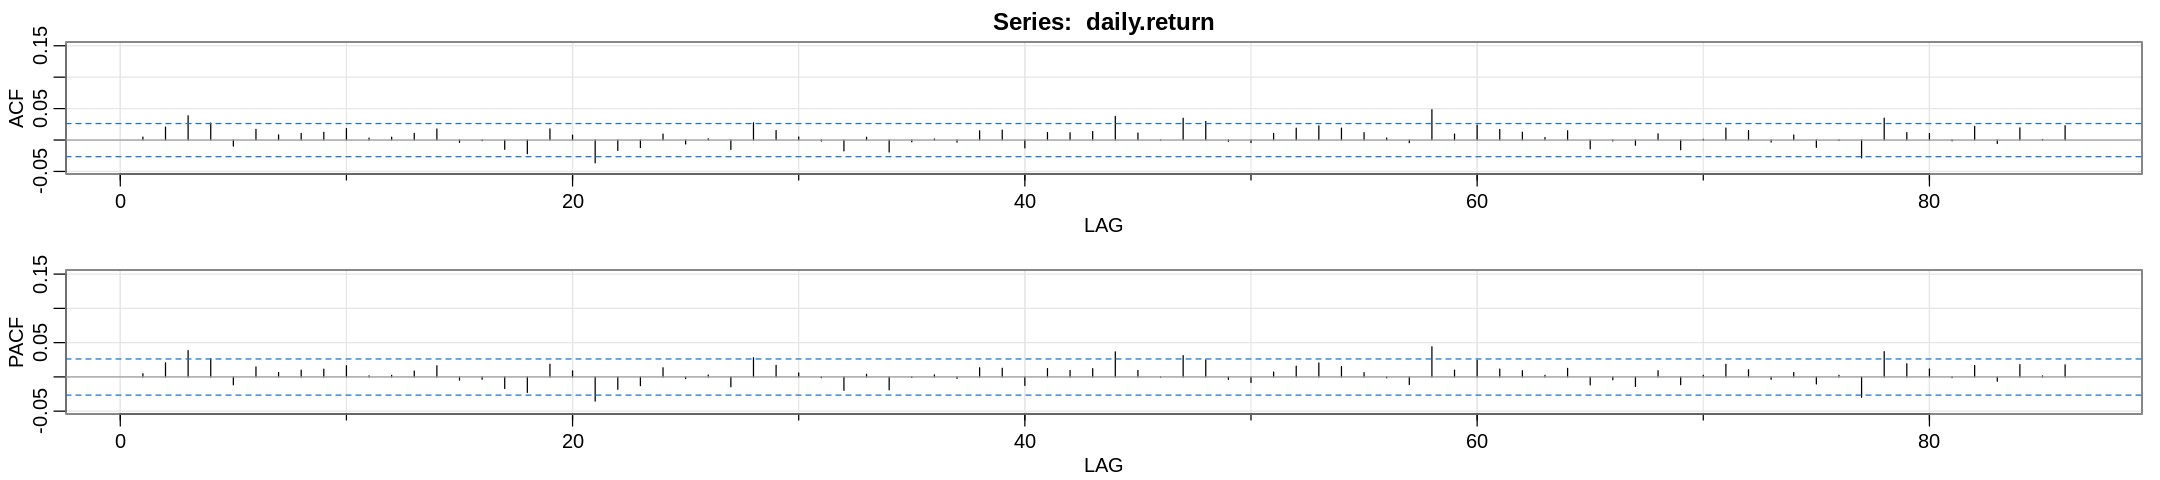

In [ ]:
acf2(daily.return)

Looking to our reference on how to interpret the lags, we really don't have a good match. 

        	AR(p)	                  MA(q)	                ARMA(p,q)
    ACF	 Tails off	              Cuts off after lag q	Tails off
    PACF    Cuts off after lag p	   Tails off	           Tails off


The next thing we do is see whether auto.arima provides any useful information. 

In [ ]:
(m = auto.arima(daily.return))
summary(m)


Series: daily.return 
ARIMA(4,1,0) 

Coefficients:
          ar1      ar2      ar3      ar4
      -0.8152  -0.6092  -0.3819  -0.1699
s.e.   0.0130   0.0161   0.0161   0.0130

sigma^2 = 0.000441:  log likelihood = 14043.87
AIC=-28077.74   AICc=-28077.73   BIC=-28044.46

Series: daily.return 
ARIMA(4,1,0) 

Coefficients:
          ar1      ar2      ar3      ar4
      -0.8152  -0.6092  -0.3819  -0.1699
s.e.   0.0130   0.0161   0.0161   0.0130

sigma^2 = 0.000441:  log likelihood = 14043.87
AIC=-28077.74   AICc=-28077.73   BIC=-28044.46

Training set error measures:
                       ME       RMSE        MAE MPE MAPE      MASE        ACF1
Training set 1.006482e-05 0.02099148 0.01560797 NaN  Inf 0.7568784 -0.02812084

Auto.arima is trying to convince us that we have have an lag 4 auto regressive process. It's also saying we should diff the data again. 

ACF,-0.51,0.00,0.01,0.01,-0.03,0.02,-0.01,0.00,0.0,0.01,⋯,-0.05,0.04,-0.01,0,-0.02,0.03,-0.03,0.02,-0.02,0.02
PACF,-0.51,-0.35,-0.25,-0.17,-0.17,-0.14,-0.12,-0.11,-0.1,-0.08,⋯,-0.04,-0.02,-0.01,0,-0.01,0.01,-0.02,0.00,-0.01,0.00


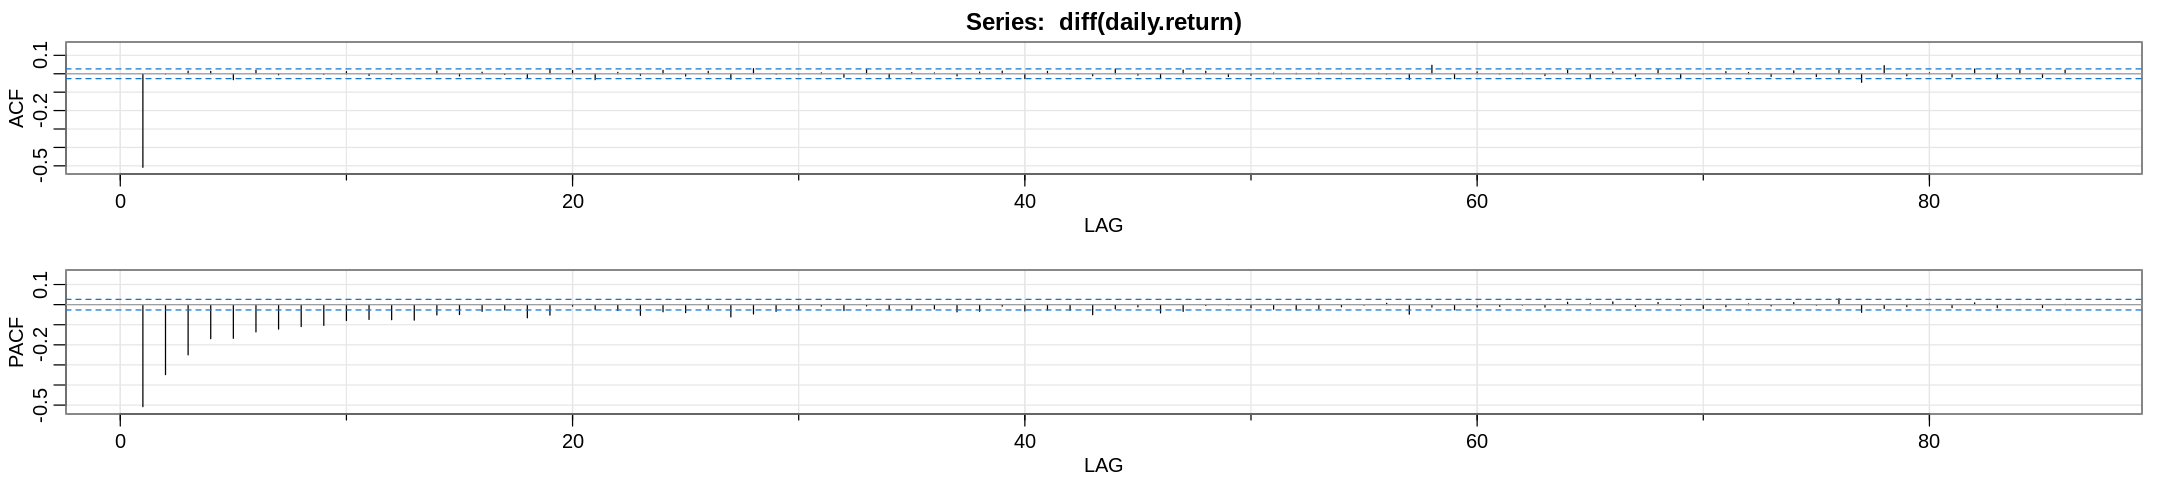

In [ ]:
acf2(diff(daily.return))

It seems that our growth rate regularly reverses in direction. But ..of course, not always. Which makes it very difficult to predict. 


initial  value -3.602692 
iter   2 value -3.752802
iter   3 value -3.808066
iter   4 value -3.840208
iter   5 value -3.862496
iter   6 value -3.863616
iter   7 value -3.864032
iter   8 value -3.864034
iter   9 value -3.864034
iter   9 value -3.864034
iter   9 value -3.864034
final  value -3.864034 
converged
initial  value -3.863475 
iter   2 value -3.863476
iter   2 value -3.863476
iter   2 value -3.863476
final  value -3.863476 
converged


$fit

Call:
arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, Q), period = S), 
    xreg = constant, transform.pars = trans, fixed = fixed, optim.control = list(trace = trc, 
        REPORT = 1, reltol = tol))

Coefficients:
          ar1      ar2      ar3      ar4  constant
      -0.8152  -0.6092  -0.3819  -0.1699     0e+00
s.e.   0.0130   0.0161   0.0161   0.0130     1e-04

sigma^2 estimated as 0.0004407:  log likelihood = 14043.87,  aic = -28075.74

$degrees_of_freedom
[1] 5740

$ttable
         Estimate     SE  t.value p.value
ar1       -0.8152 0.0130 -62.6517  0.0000
ar2       -0.6092 0.0161 -37.7992  0.0000
ar3       -0.3819 0.0161 -23.6933  0.0000
ar4       -0.1699 0.0130 -13.0618  0.0000
constant   0.0000 0.0001   0.0064  0.9949

$AIC
[1] -4.886986

$AICc
[1] -4.886984

$BIC
[1] -4.880035


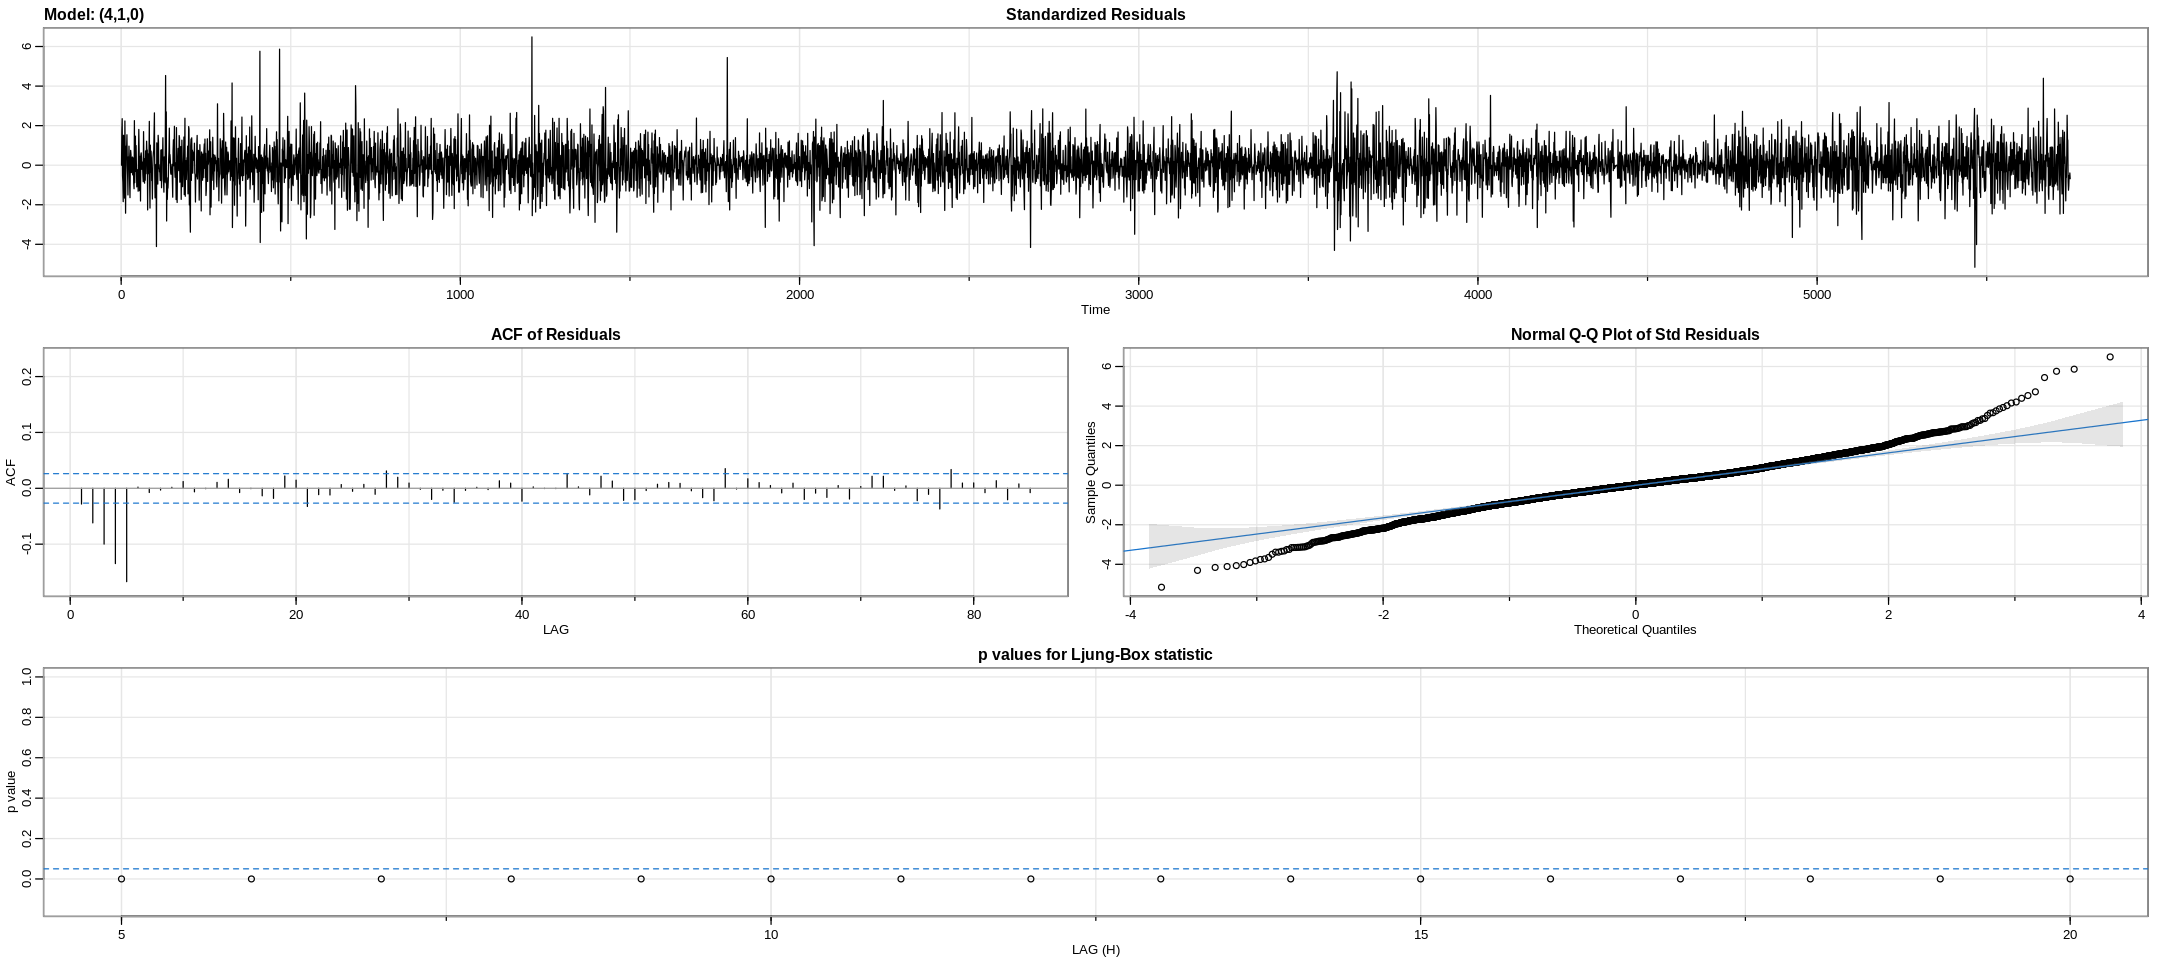

In [ ]:
options(repr.plot.width=18, repr.plot.height=8)

sarima(daily.return, 4, 1, 0)

initial  value -3.602373 
iter   2 value -3.812210
iter   3 value -3.875113
iter   4 value -3.932425
iter   5 value -3.934091
iter   6 value -3.934787
iter   7 value -3.934972
iter   8 value -3.934988
iter   9 value -3.934992
iter  10 value -3.935053
iter  11 value -3.935055
iter  11 value -3.935055
final  value -3.935055 
converged
initial  value -3.941506 
iter   2 value -3.942969
iter   3 value -3.943268
iter   4 value -3.944409
iter   5 value -3.945581
iter   6 value -3.945978
iter   7 value -3.946312
iter   8 value -3.946813
iter   9 value -3.947652
iter  10 value -3.947658
iter  11 value -3.947675
iter  12 value -3.947679
iter  12 value -3.947679
iter  13 value -3.947679
iter  13 value -3.947679
iter  13 value -3.947679
final  value -3.947679 
converged


Warning message in sqrt(diag(fitit$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(fitit$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”


$fit

Call:
arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, Q), period = S), 
    xreg = constant, transform.pars = trans, fixed = fixed, optim.control = list(trace = trc, 
        REPORT = 1, reltol = tol))

Coefficients:
          ma1  constant
      -0.9969         0
s.e.      NaN       NaN

sigma^2 estimated as 0.0003721:  log likelihood = 14527.61,  aic = -29049.22

$degrees_of_freedom
[1] 5743

$ttable
         Estimate  SE t.value p.value
ma1       -0.9969 NaN     NaN     NaN
constant   0.0000 NaN     NaN     NaN

$AIC
[1] -5.056436

$AICc
[1] -5.056436

$BIC
[1] -5.05296


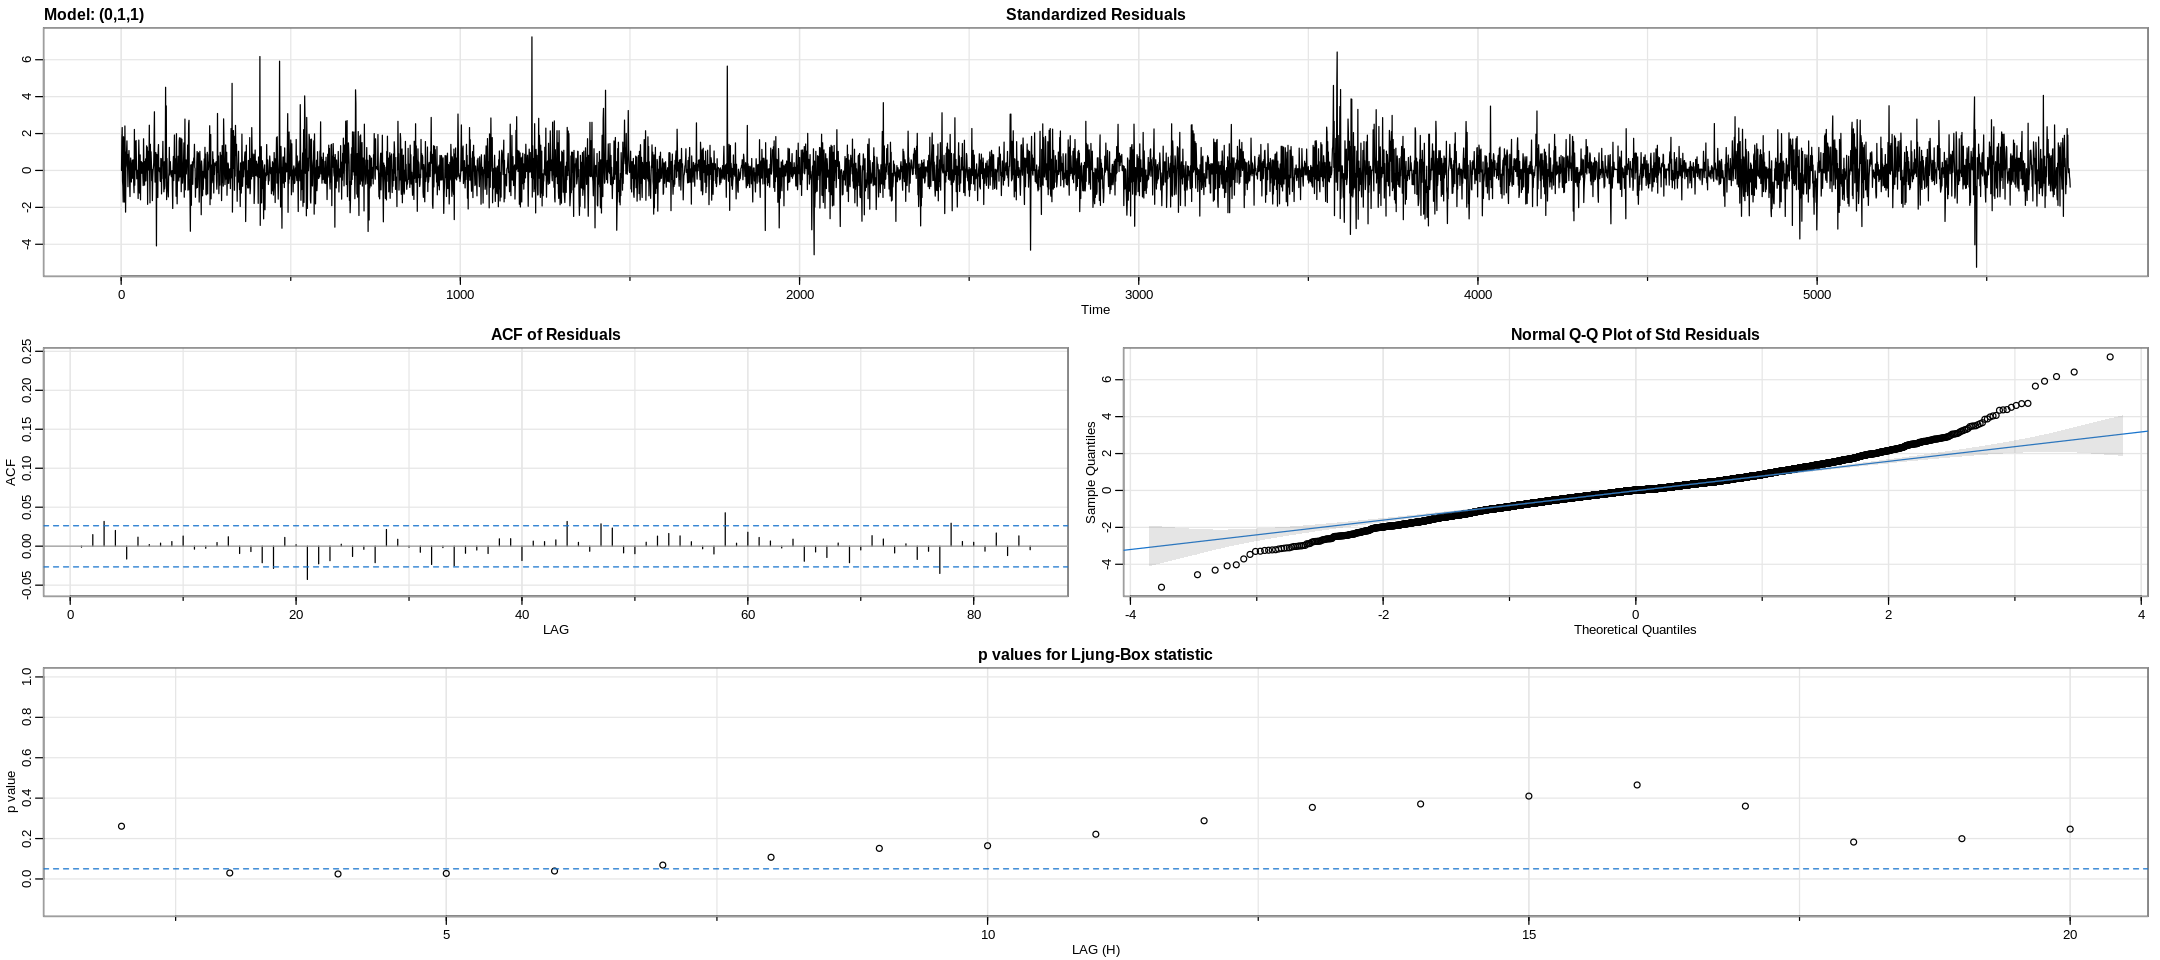

In [ ]:
sarima(daily.return, 0,1, 1)

Auto.arima seems to be discovering the wrong process and it seems related to a certain method of calculating the pvalues on the MA coefficients. In the next step we verify by using an alternate library and show that the AIC is better using an arima (0, 1, 1) model. 

In [ ]:
Arima(daily.return, order=c(4,1,0))
Arima(daily.return, order=c(0,1,1))

Series: daily.return 
ARIMA(4,1,0) 

Coefficients:
          ar1      ar2      ar3      ar4
      -0.8152  -0.6092  -0.3819  -0.1699
s.e.   0.0130   0.0161   0.0161   0.0130

sigma^2 = 0.000441:  log likelihood = 14043.87
AIC=-28077.74   AICc=-28077.73   BIC=-28044.46

Series: daily.return 
ARIMA(0,1,1) 

Coefficients:
          ma1
      -0.9968
s.e.   0.0012

sigma^2 = 0.0003722:  log likelihood = 14527.59
AIC=-29051.18   AICc=-29051.18   BIC=-29037.87

SARIMA Model seems to be preforming poorly as seen by lots of the end values of our QQ plots not landing within the correct intervals as well as our p-values all sticking too the dotted line or below.

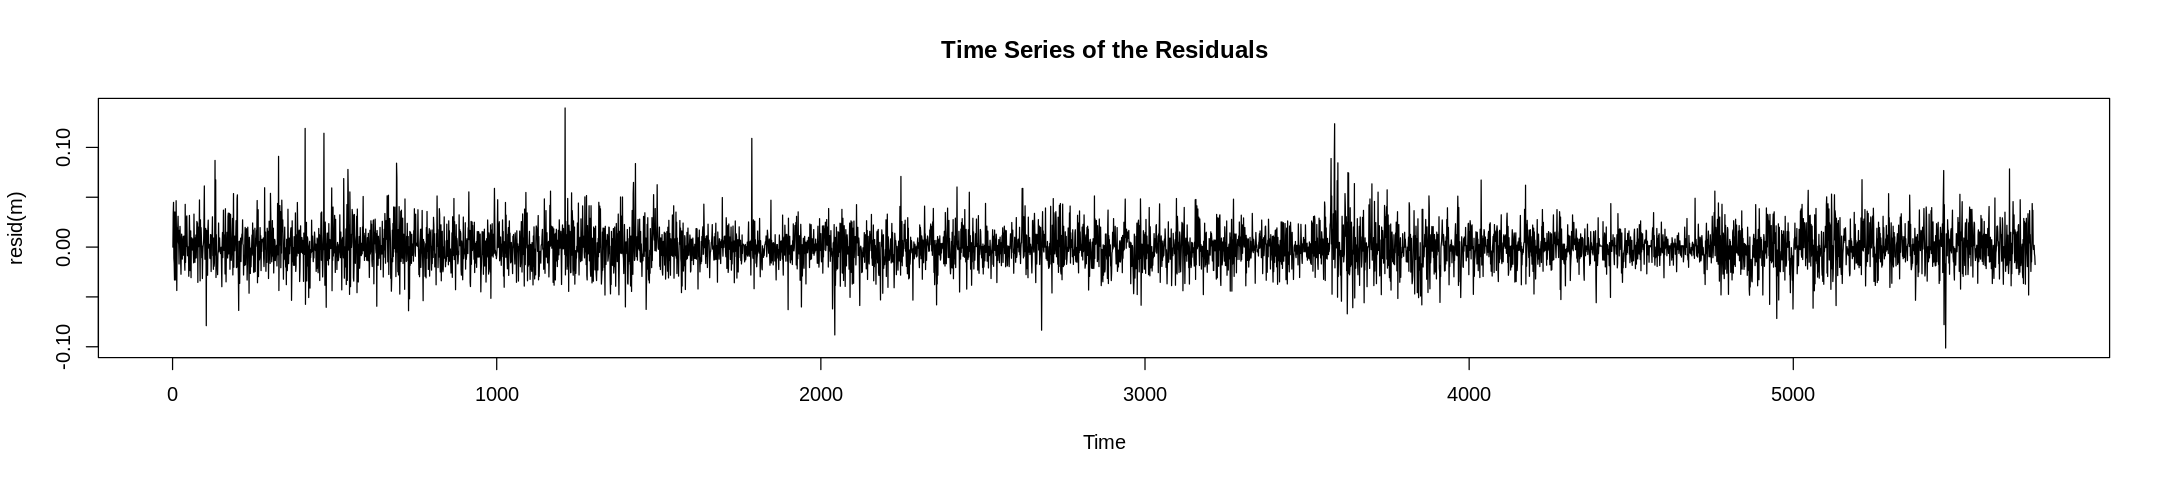

ACF,0,0.01,0.03,0.02,-0.02,0.01,0,0,0.01,0.01,⋯,-0.03,0.03,0.01,0.00,-0.01,0.02,-0.01,0.01,0,0.02
PACF,0,0.01,0.03,0.02,-0.02,0.01,0,0,0.01,0.01,⋯,-0.03,0.03,0.02,0.01,0.00,0.01,-0.01,0.01,0,0.01


Loading required package: carData



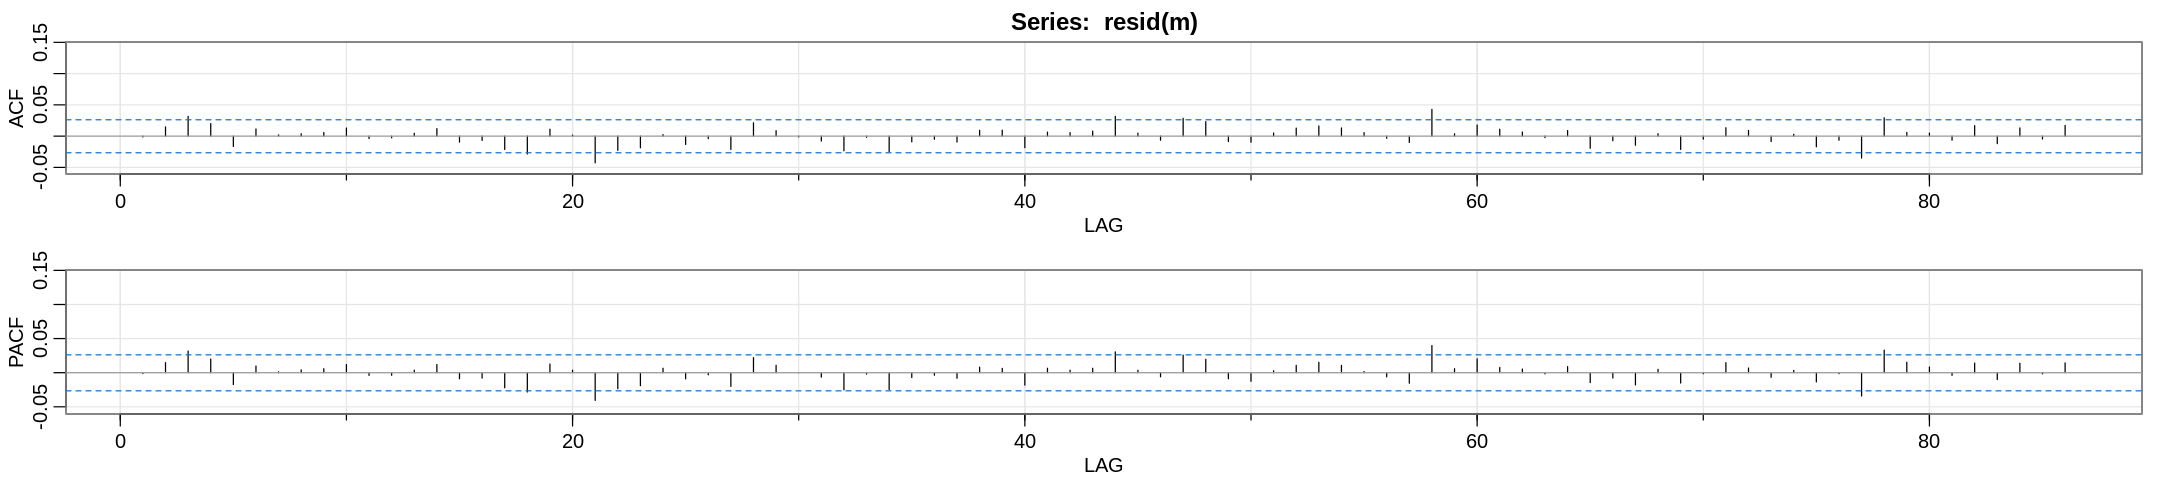

[1] 1211 3585

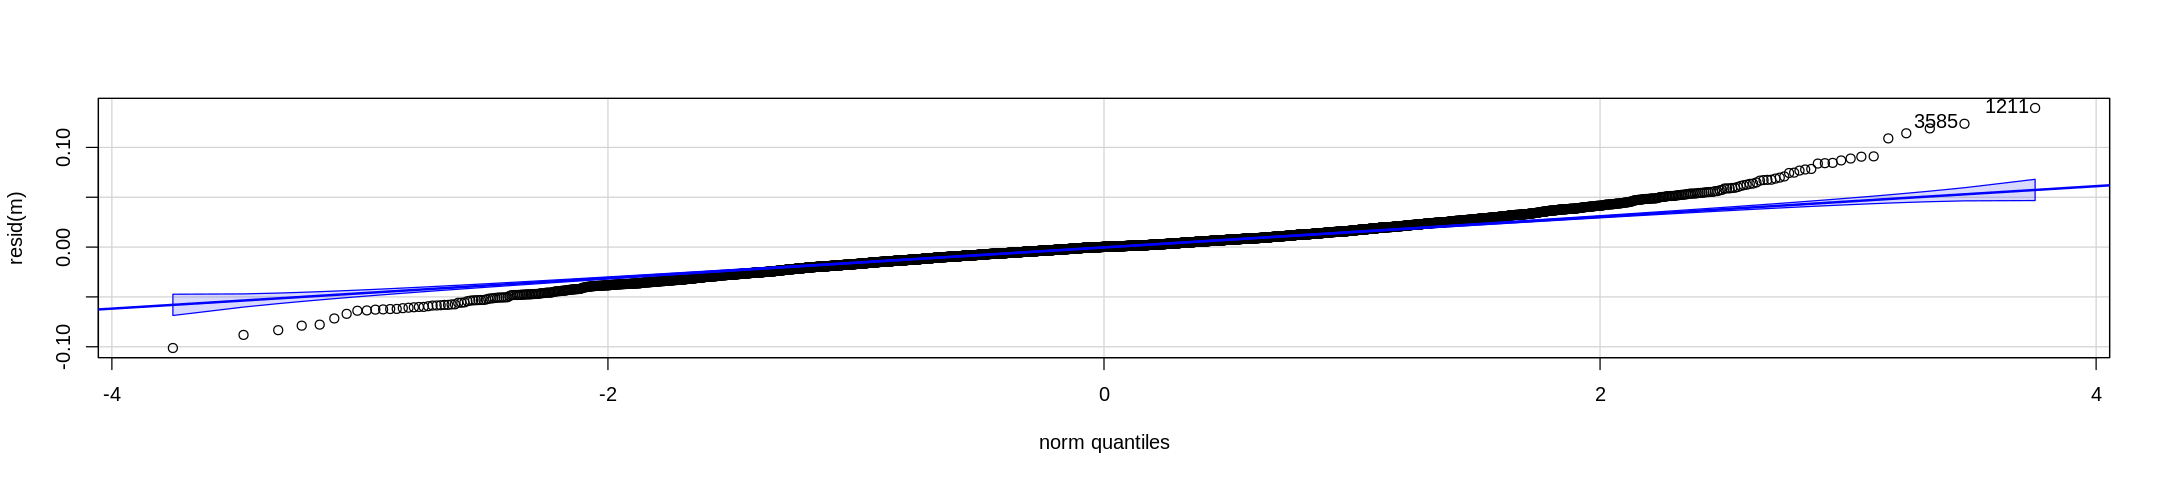

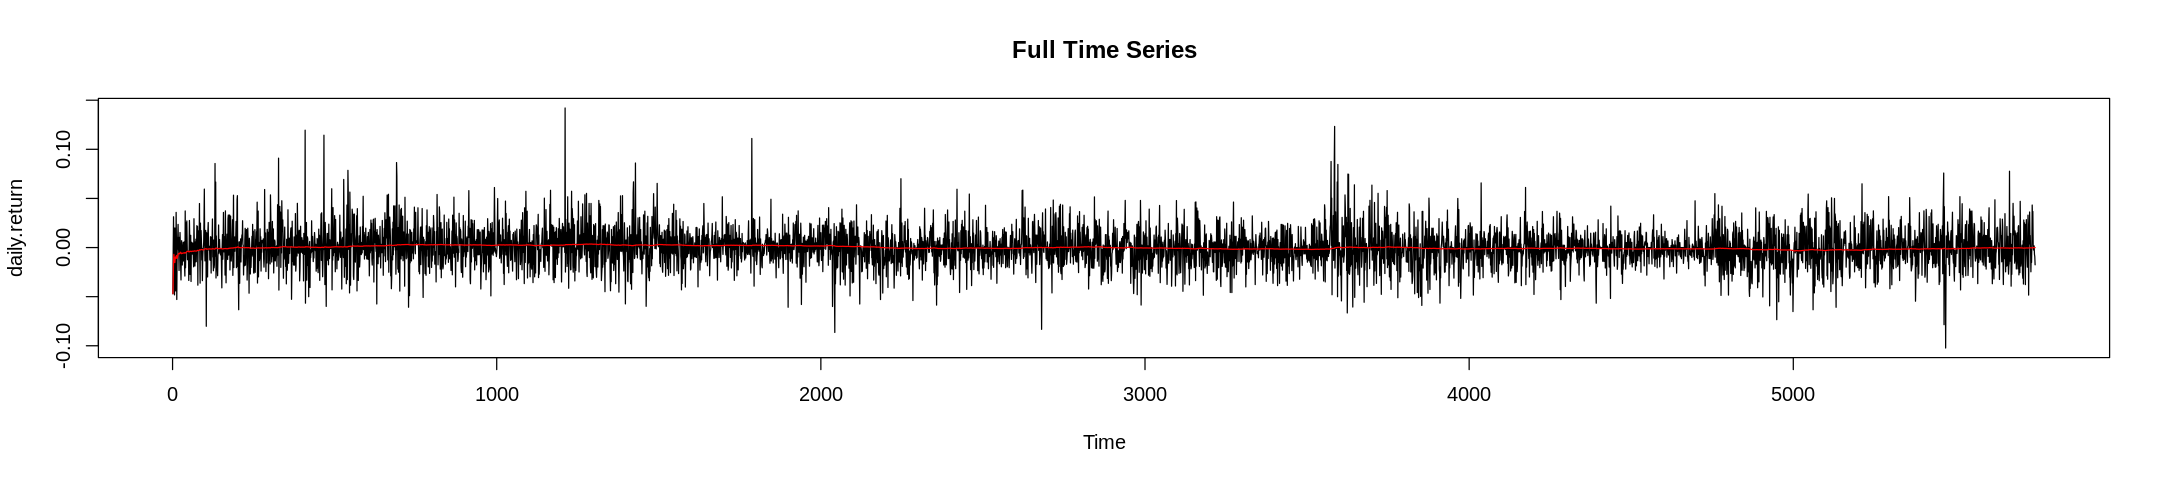

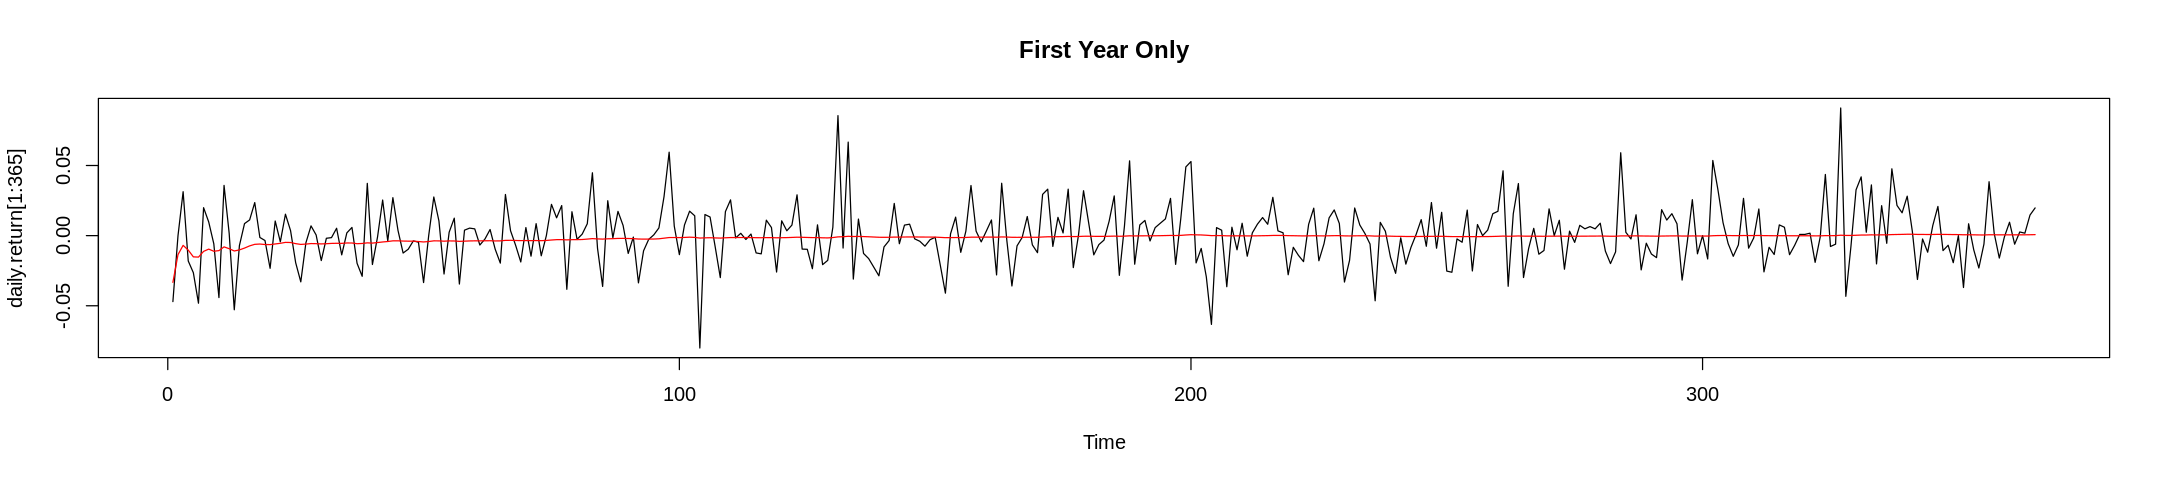

In [ ]:
m=Arima(daily.return, order=c(0,1,1)) # (close - open) / close
options(repr.plot.width=18, repr.plot.height=4)
plot(resid(m), main="Time Series of the Residuals")
acf2(resid(m))
options(repr.plot.width=18, repr.plot.height=8)
library(car)
options(repr.plot.width=18, repr.plot.height=4)
qqPlot(resid(m))
plot(daily.return, main = "Full Time Series")
lines(fitted.values(m), col="red")
plot.ts(daily.return[1:365], main = "First Year Only")
lines(lag(fitted.values(m)[2:366], -1), col="red")

Unfortunately, it seems as though we can't do much better than an averaging process using a univariate MA process. 

The next piece explores the relationship between our residuals and other variables. 

Although we're finding relationships between the errors and other variables, it's difficult to see whether they will be useful for forecasting. 

The diffed values of other variables seem to have some potential. 

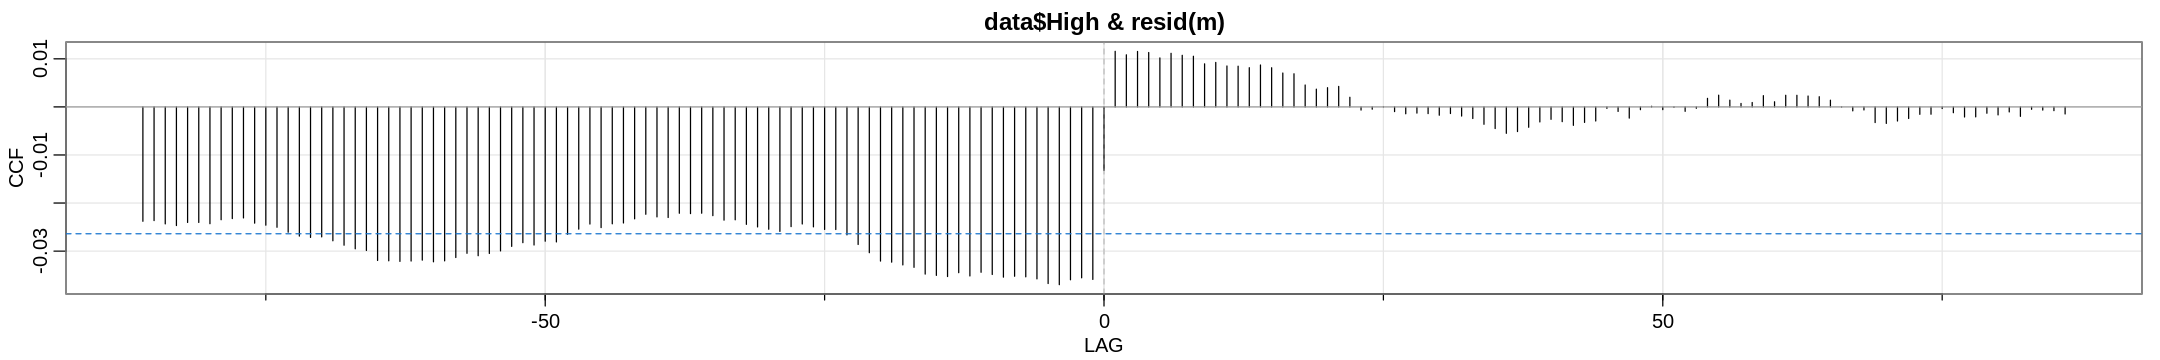

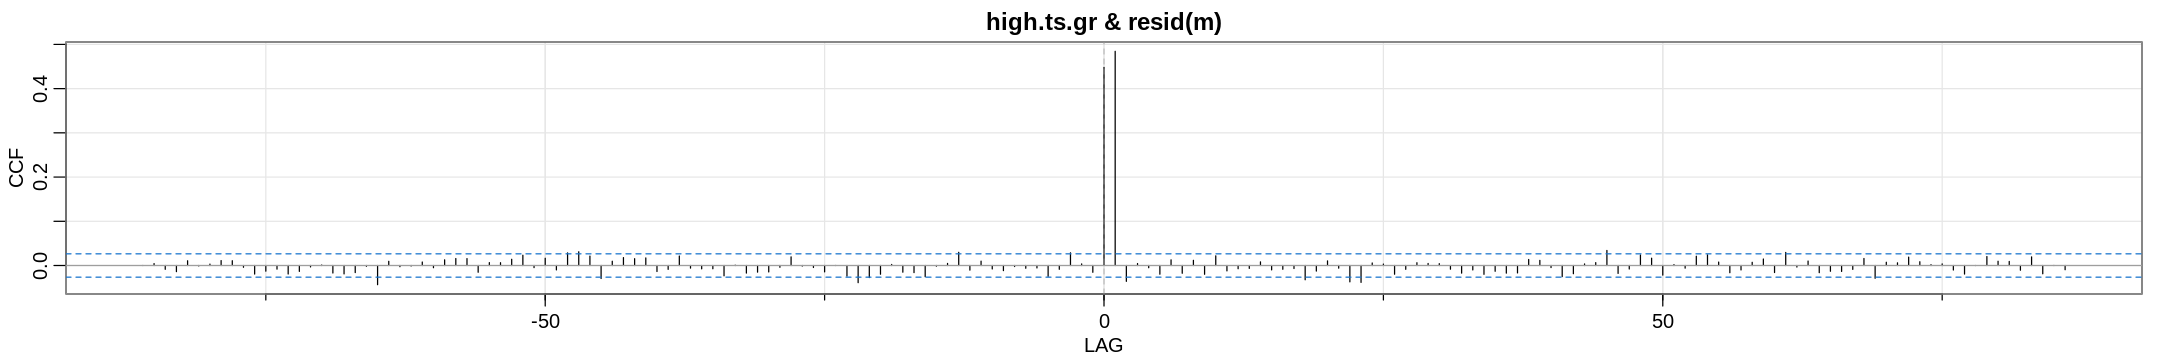

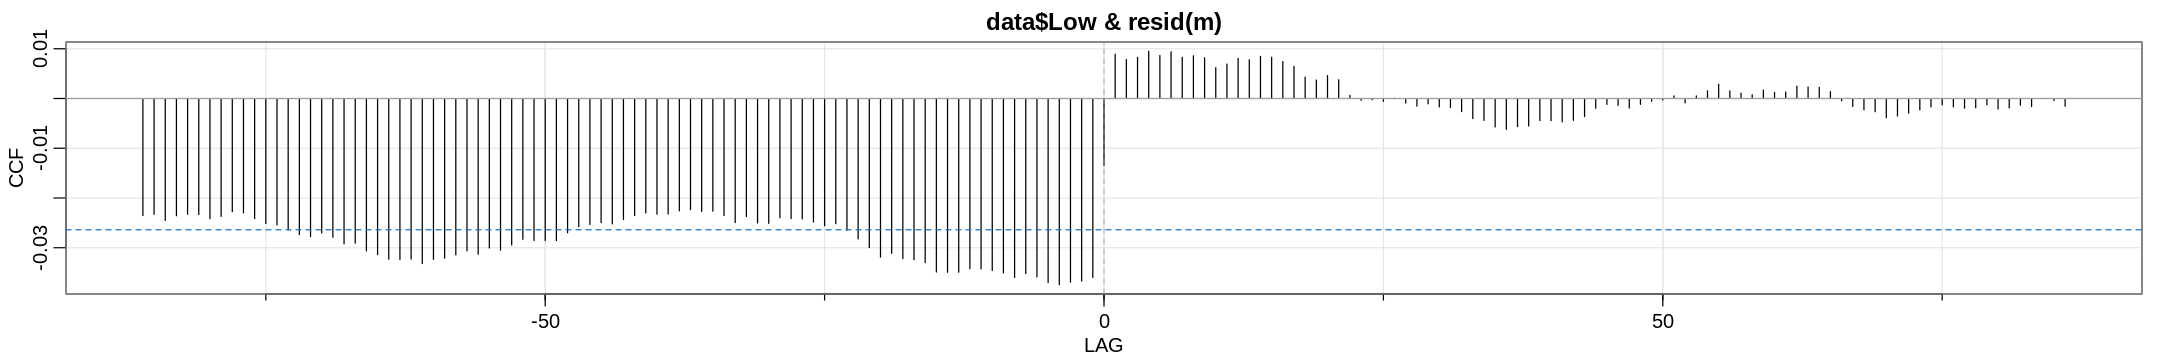

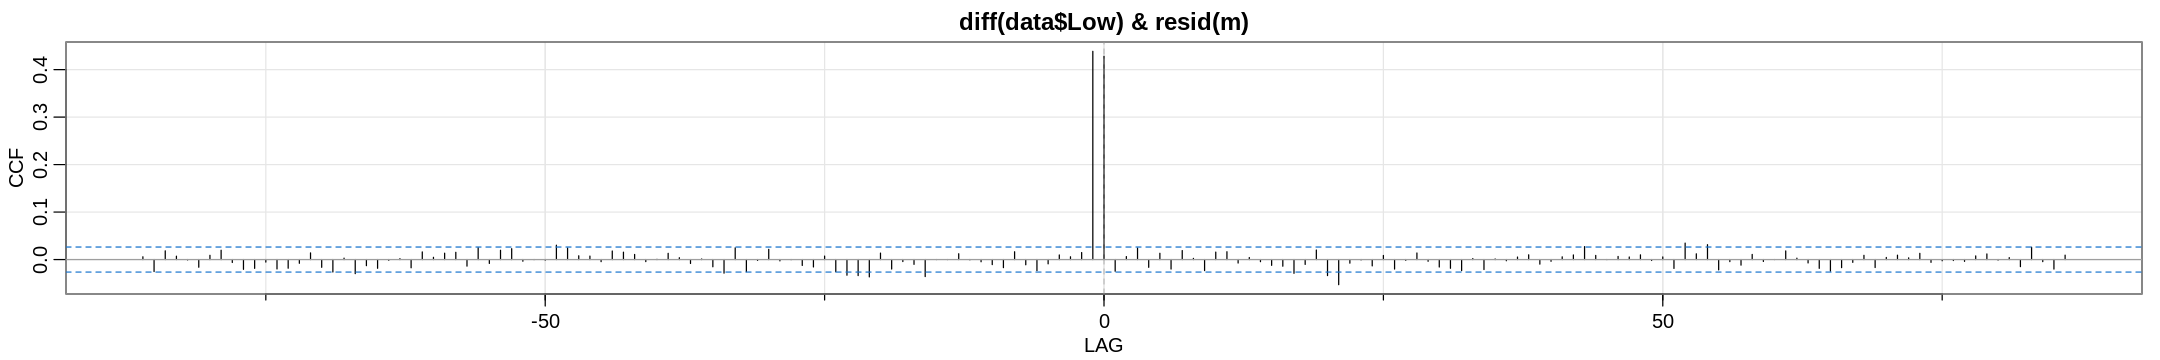

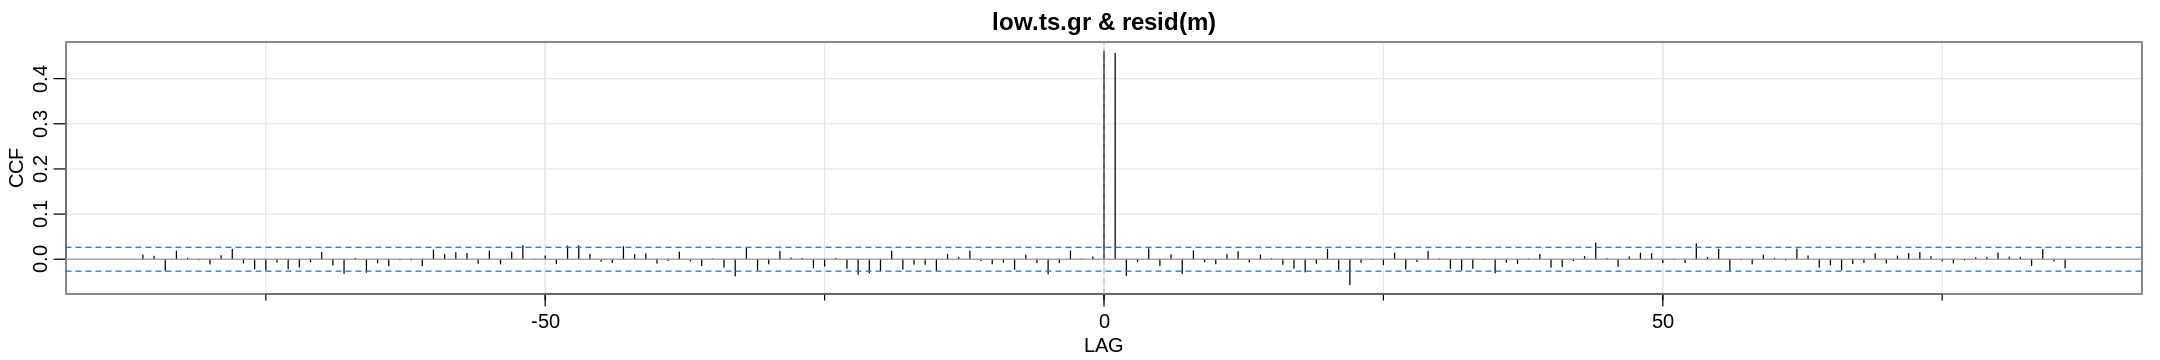

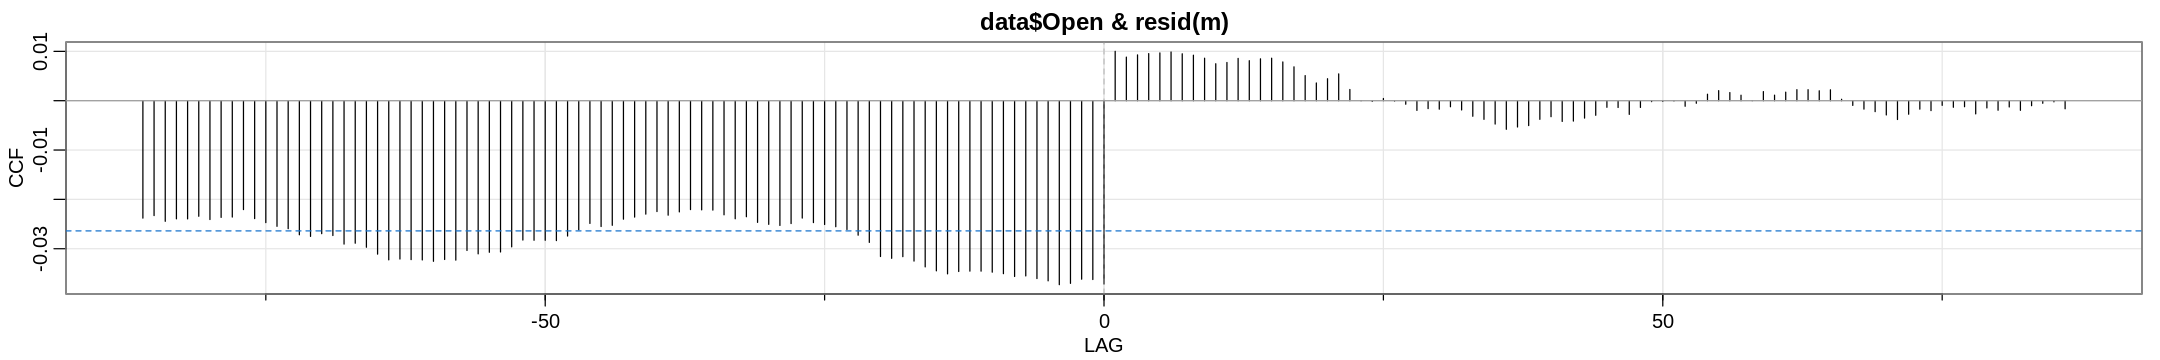

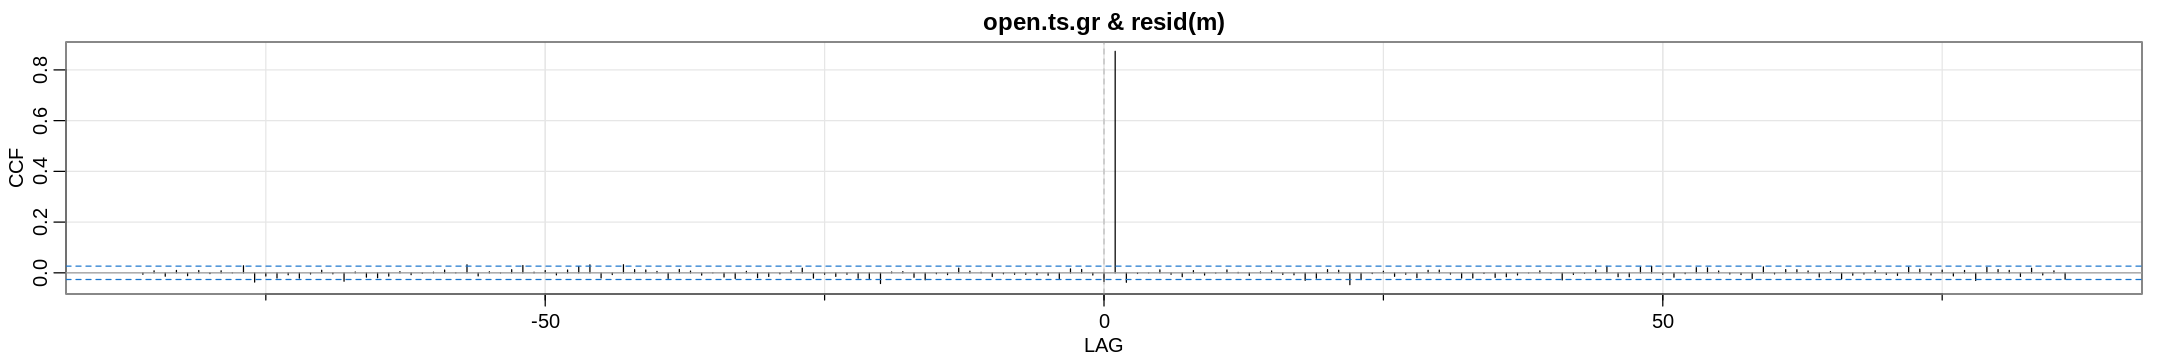

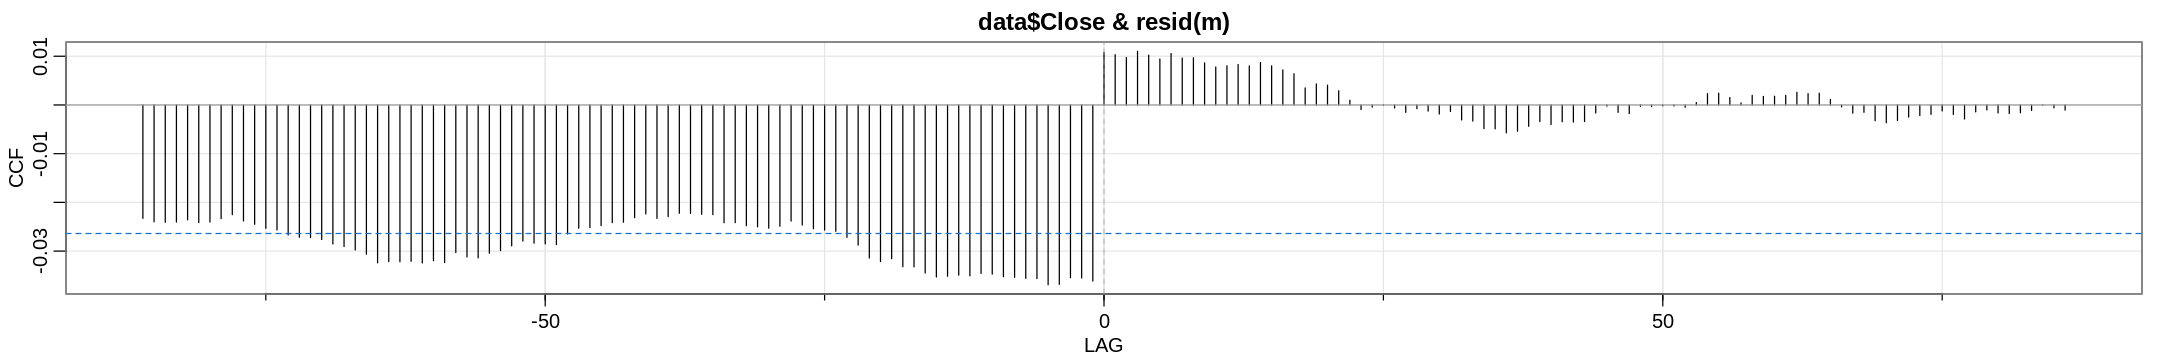

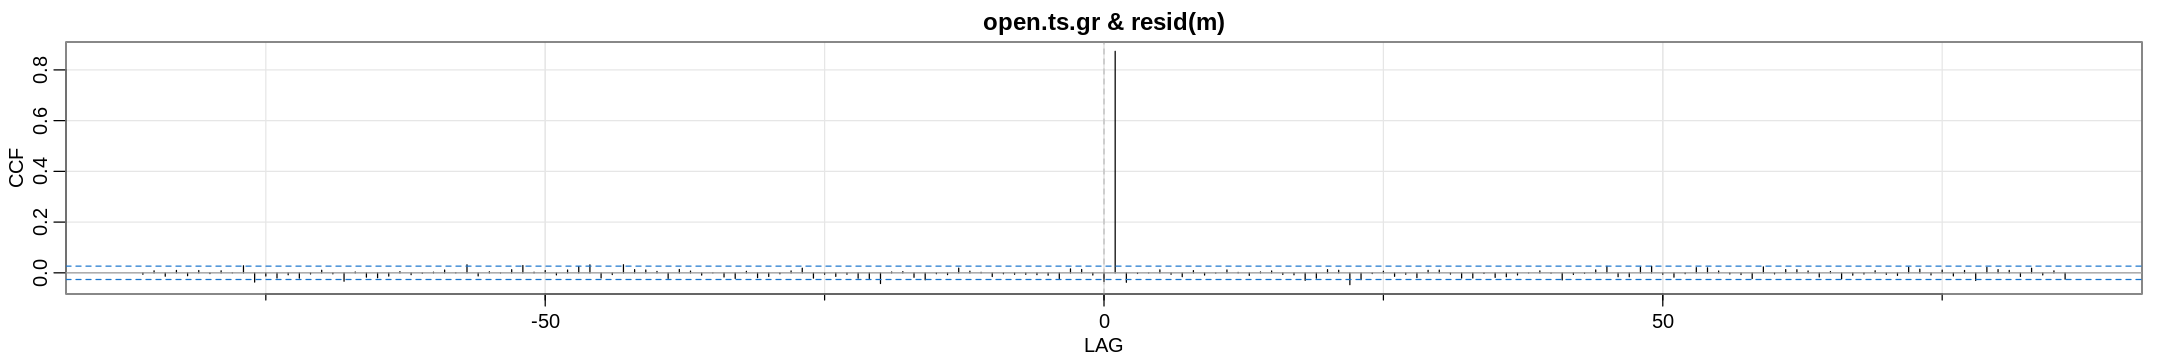

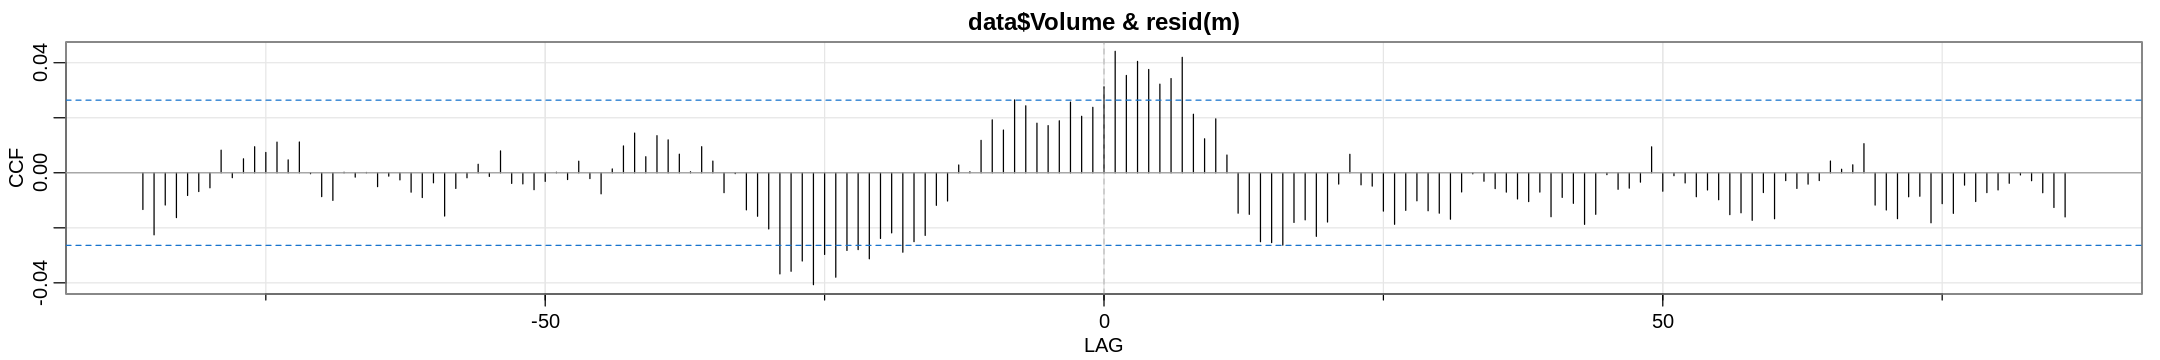

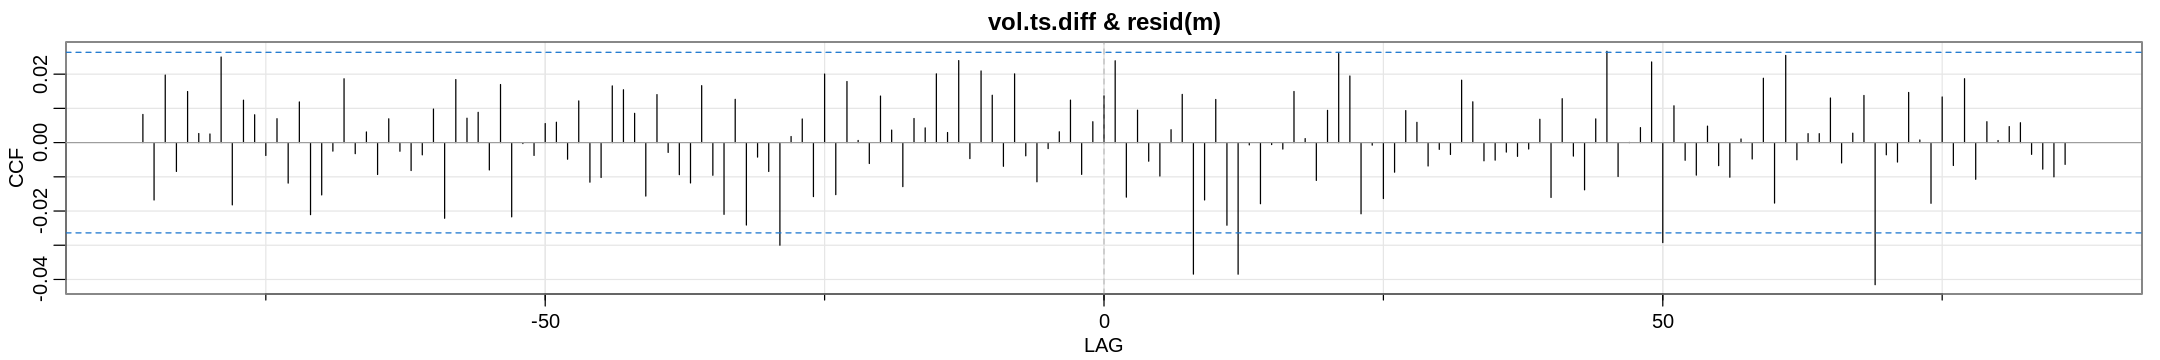

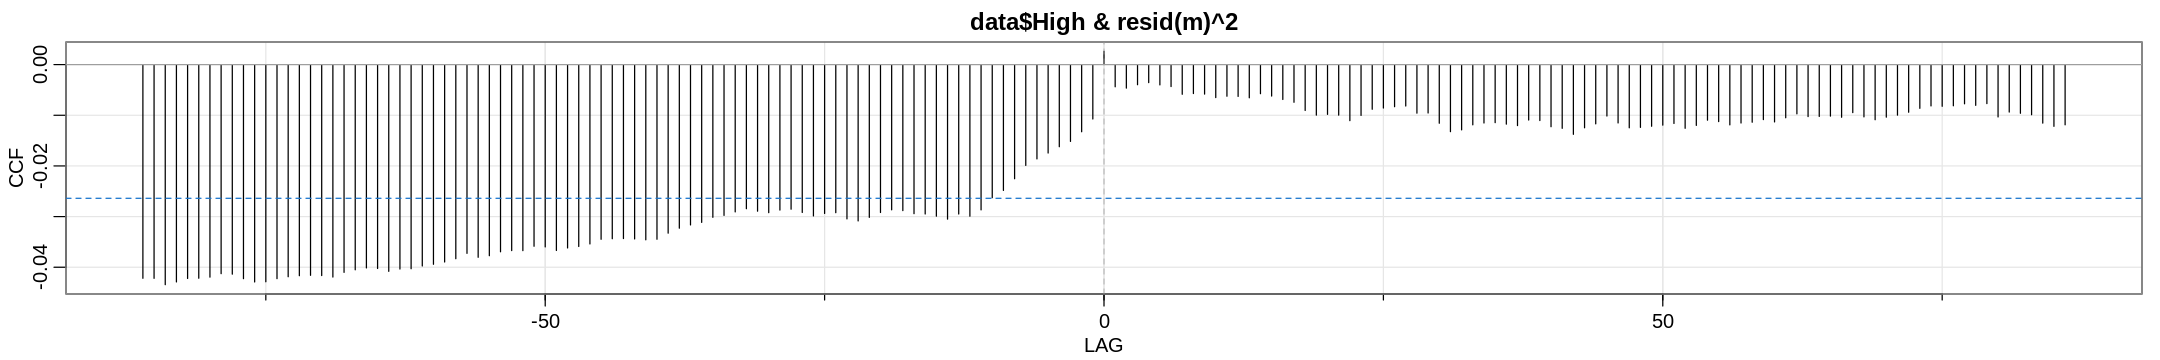

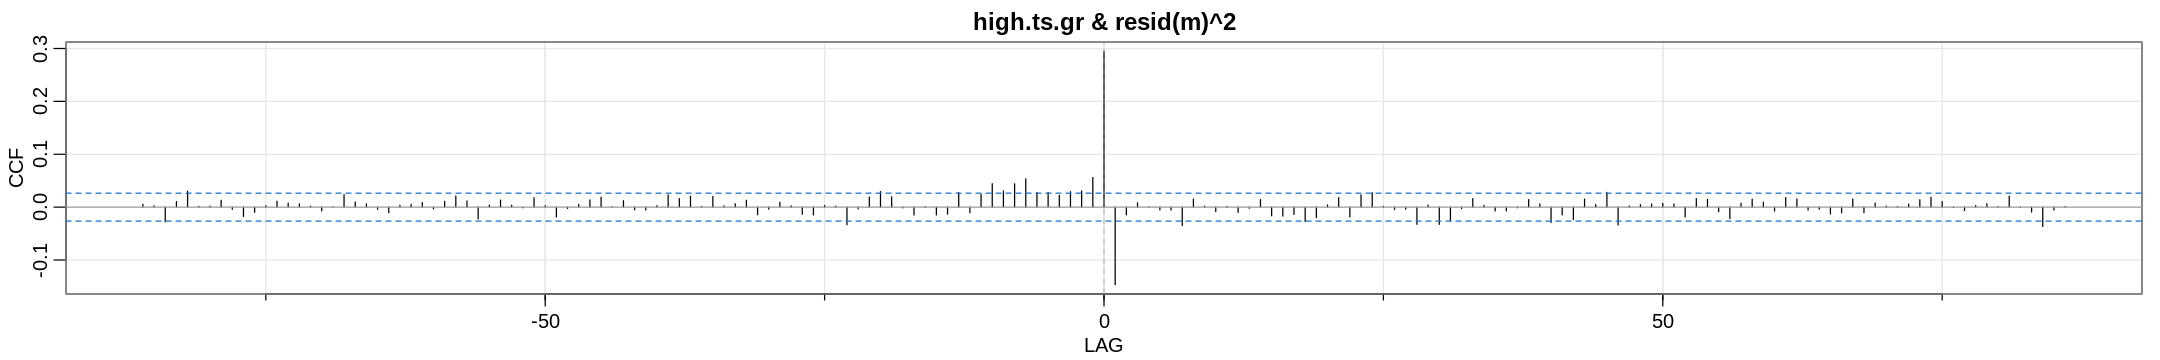

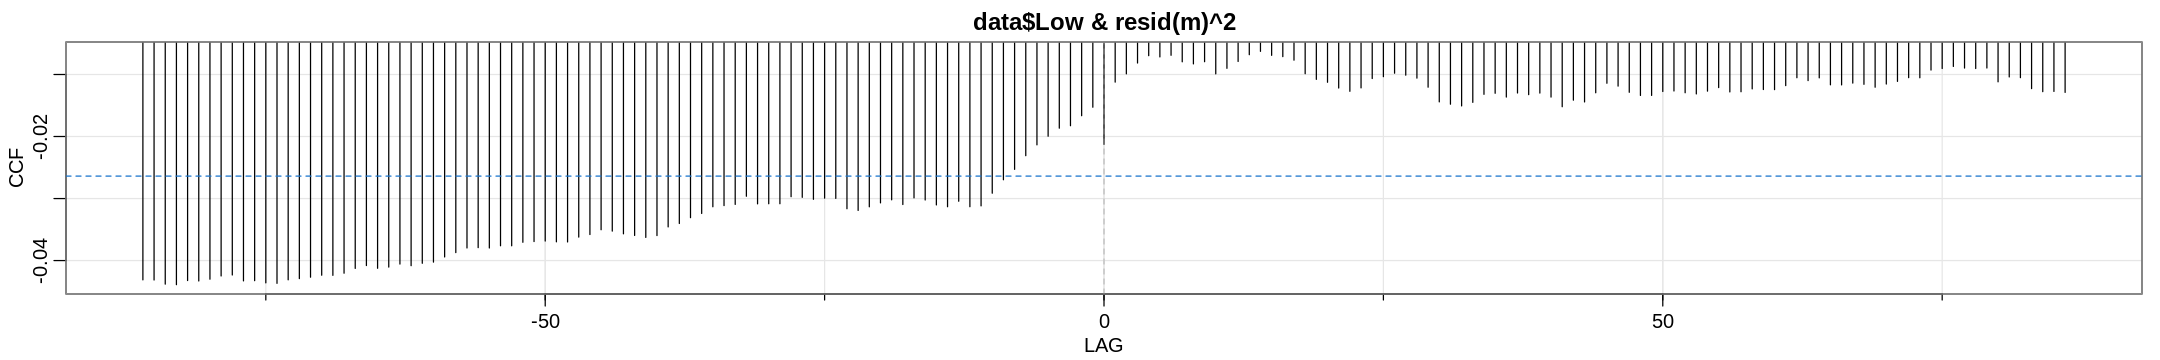

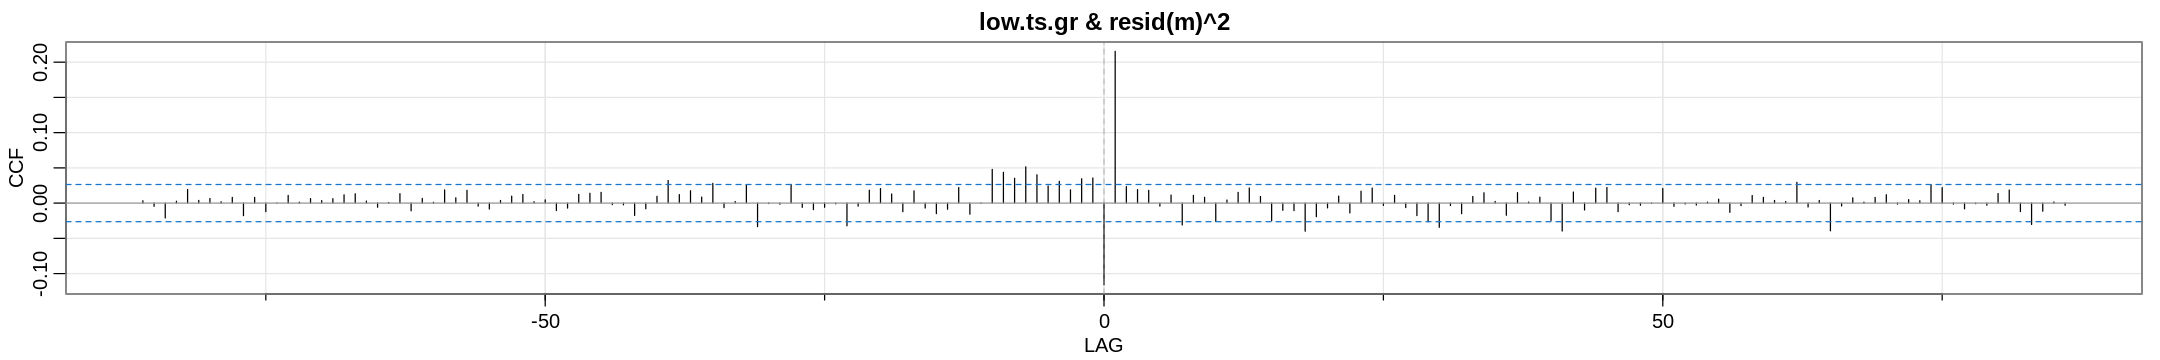

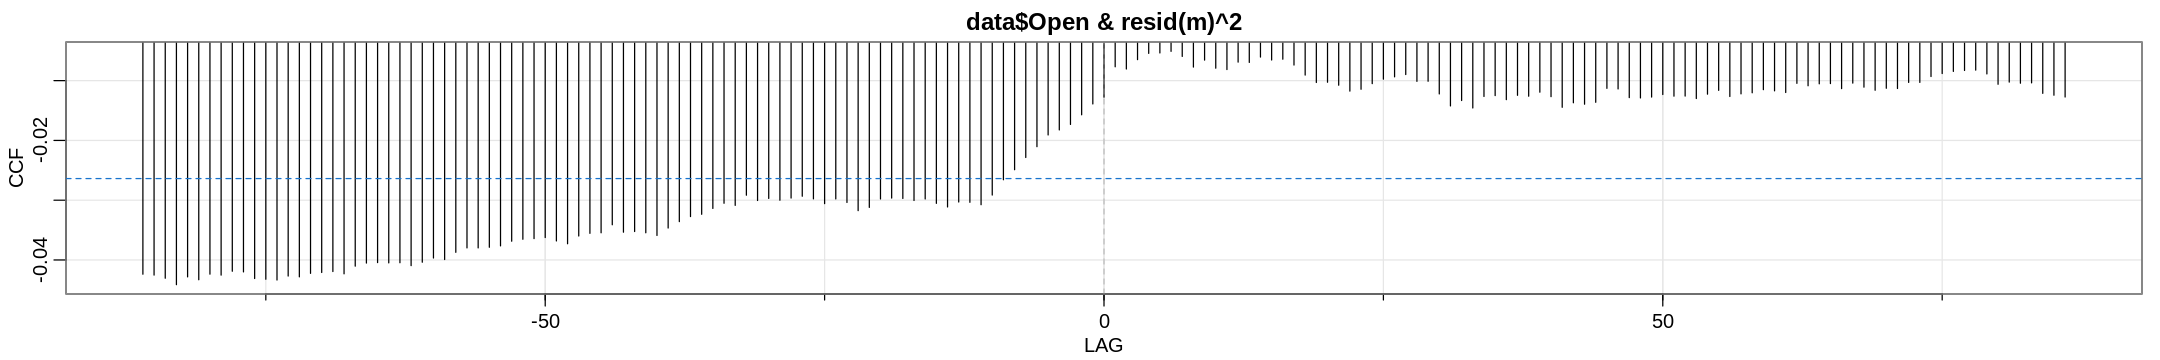

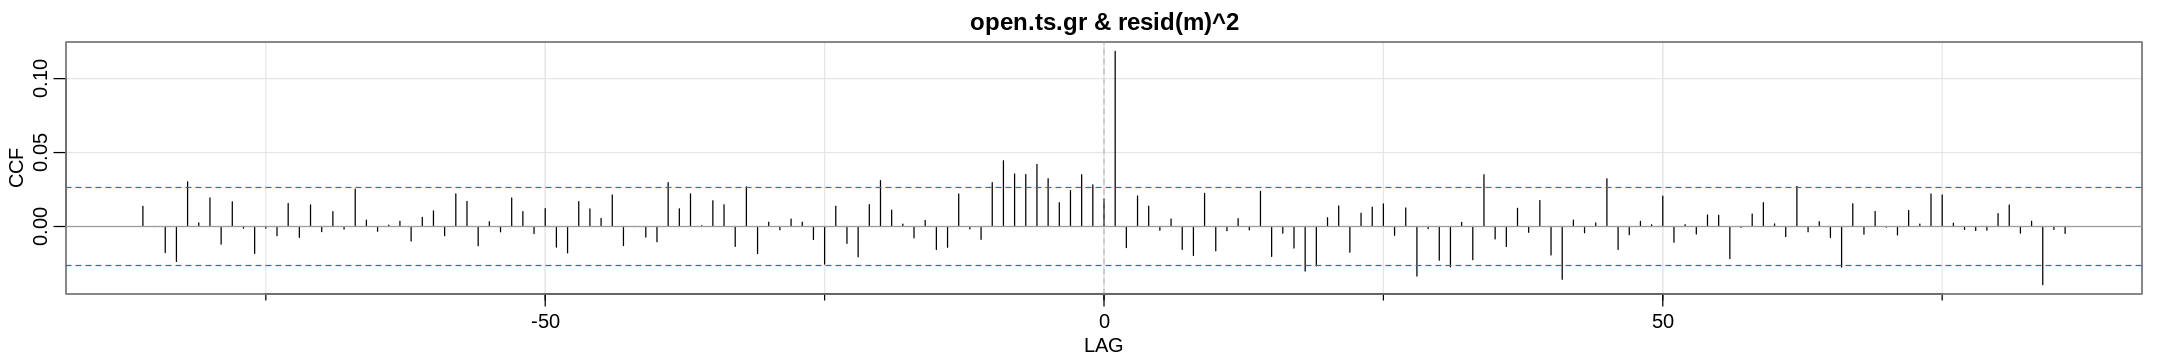

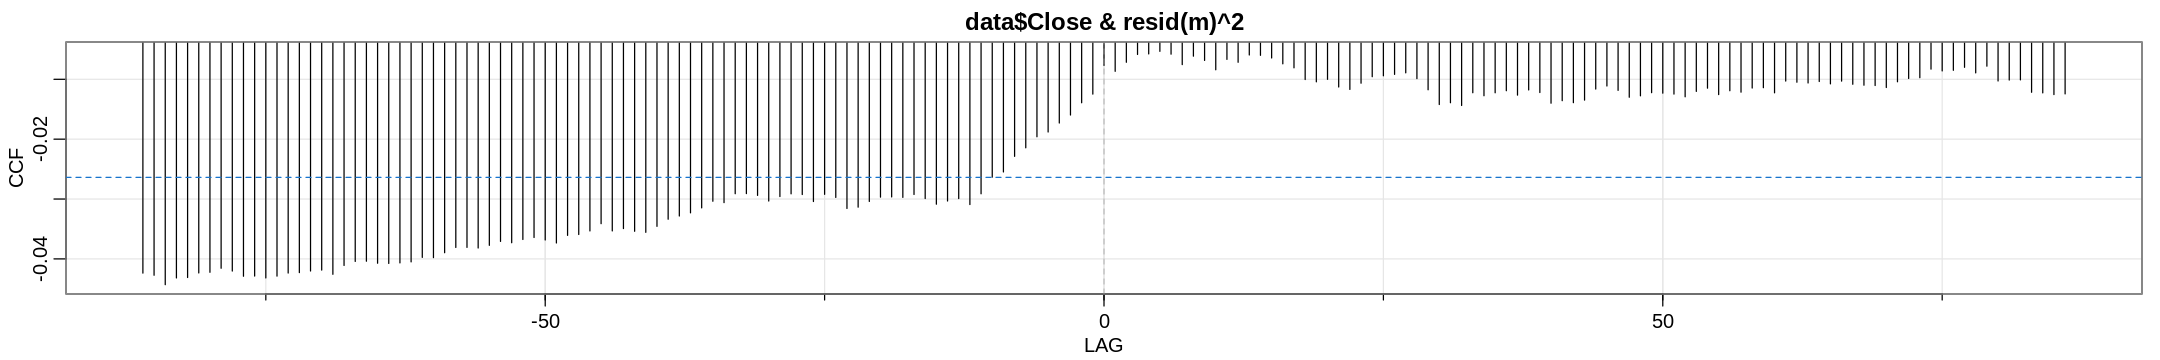

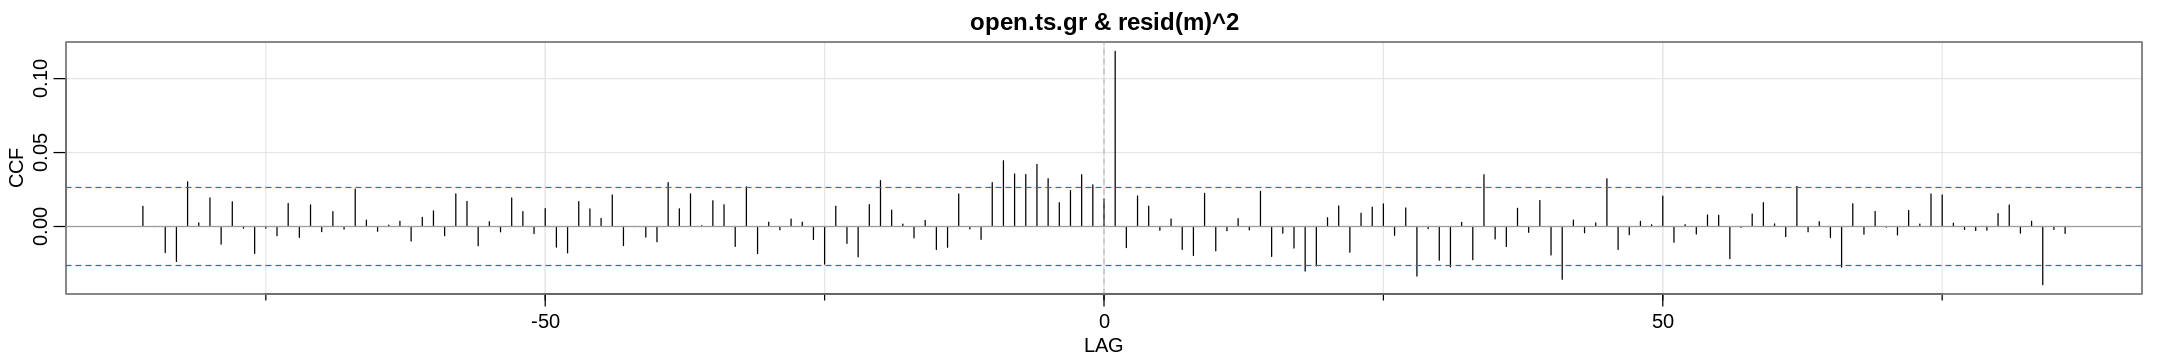

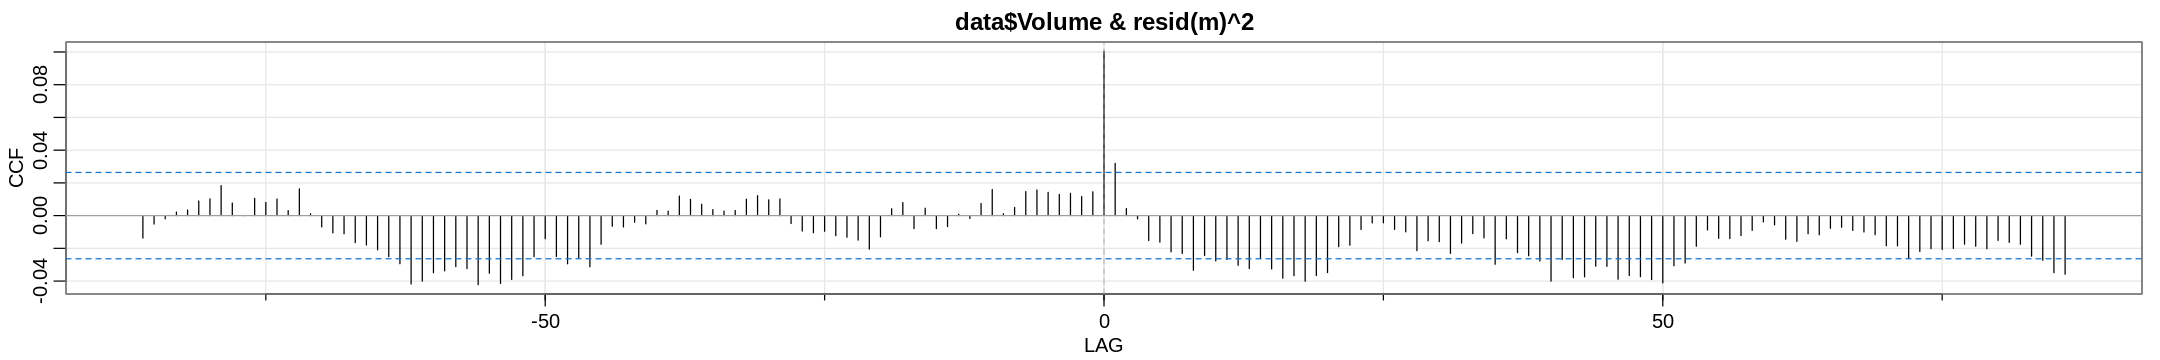

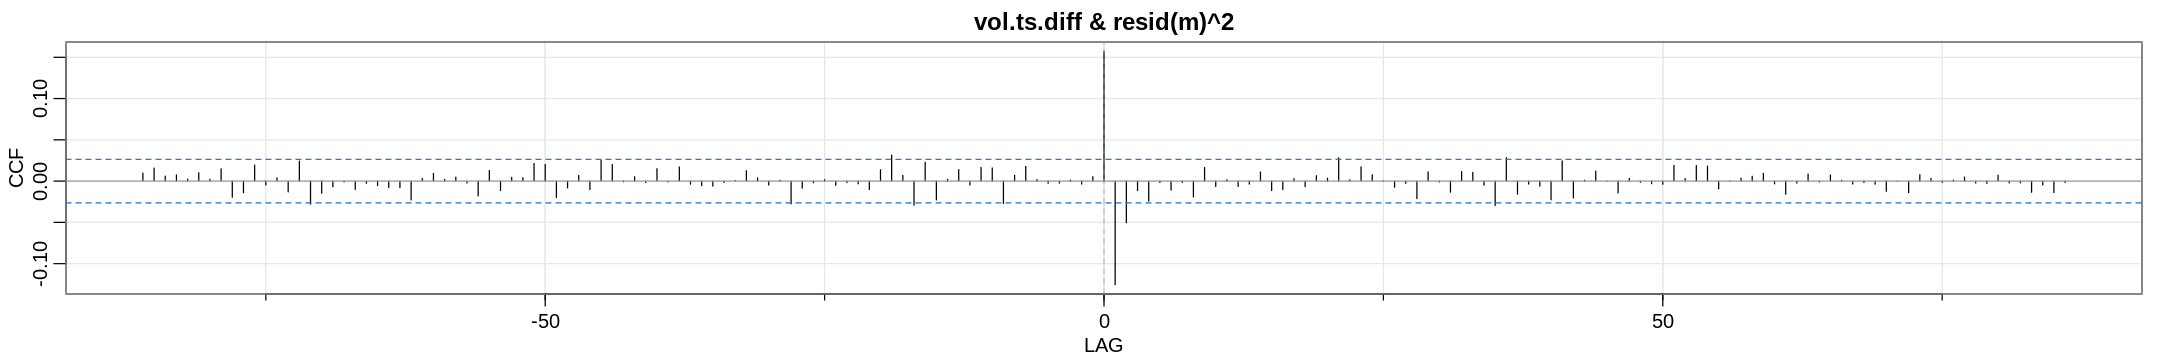

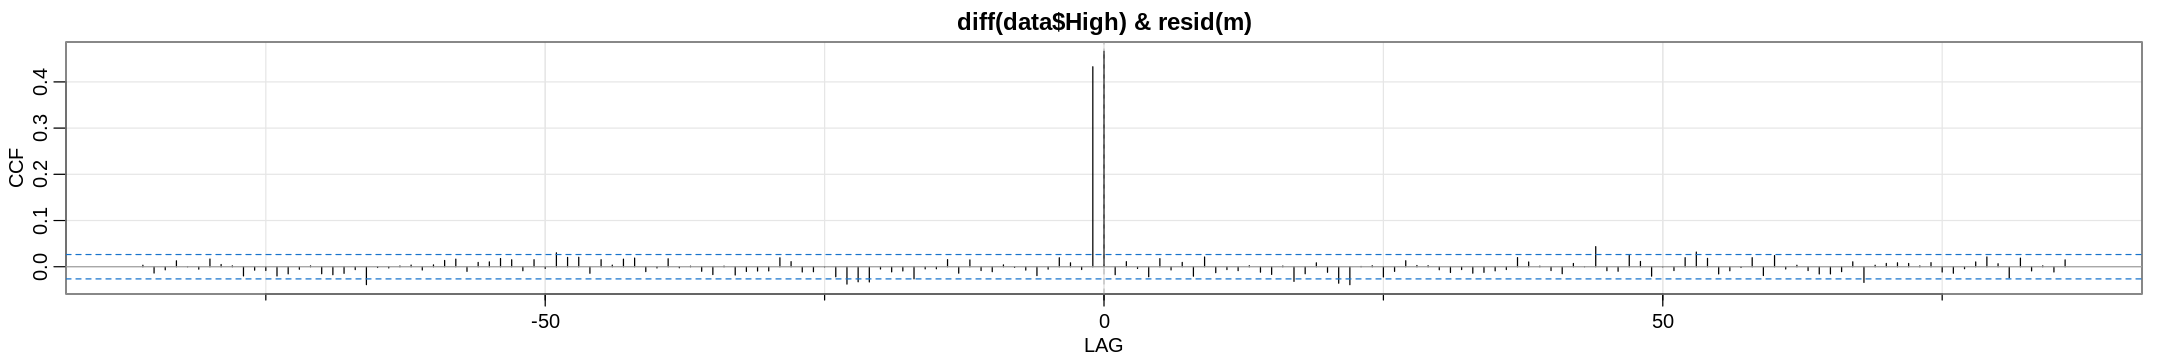

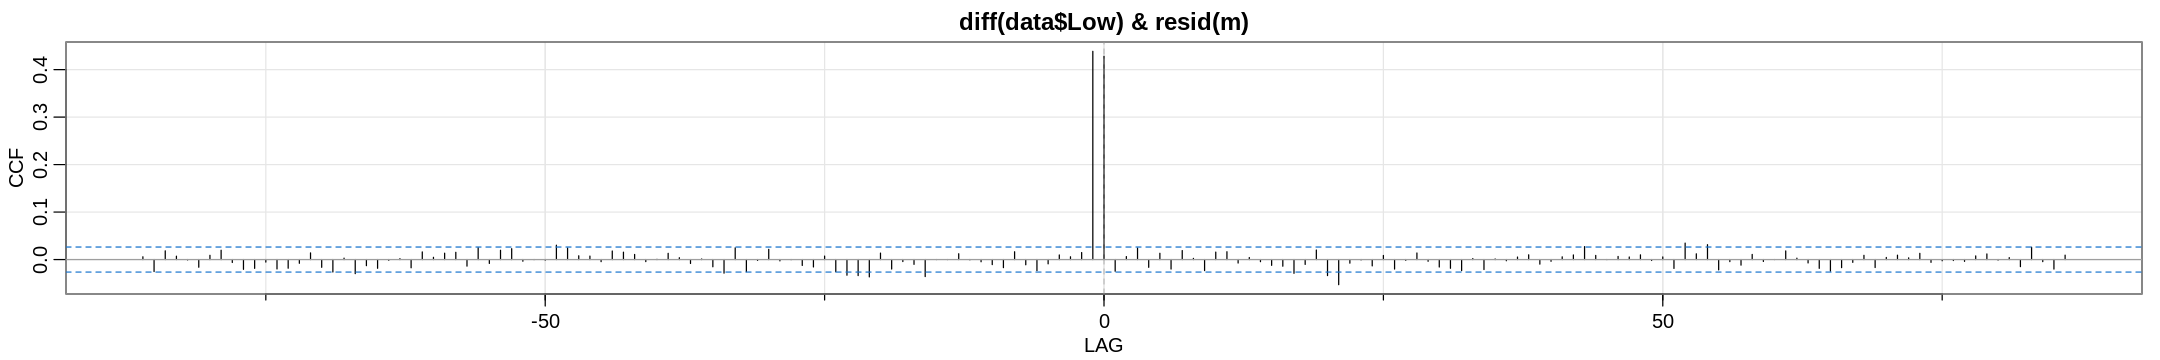

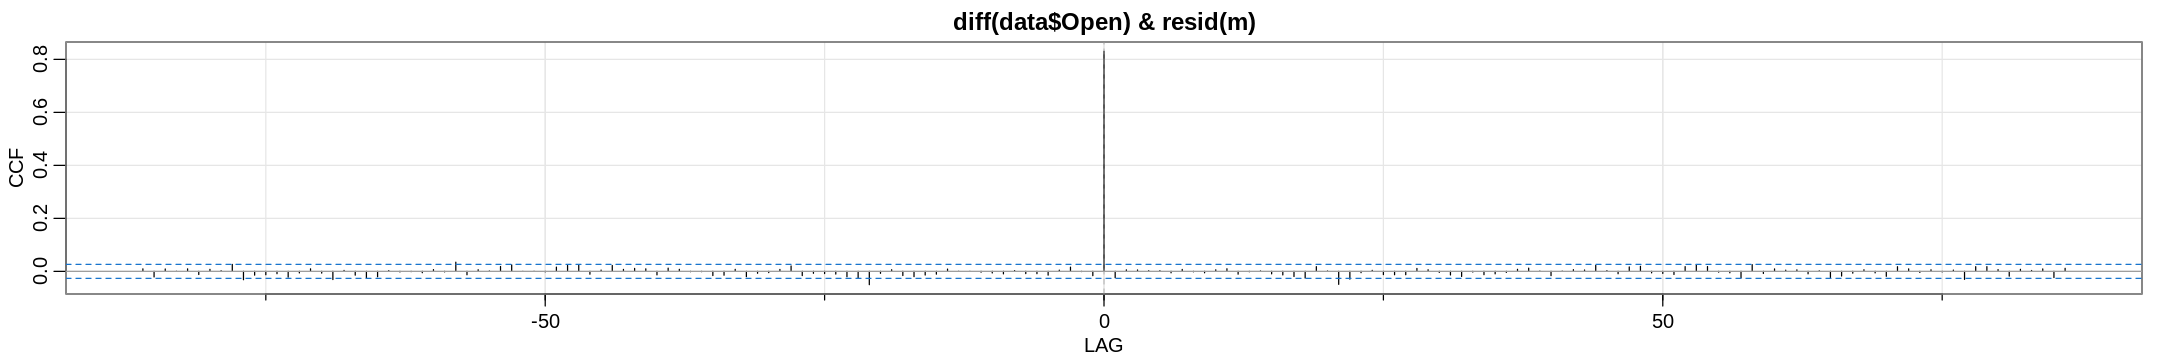

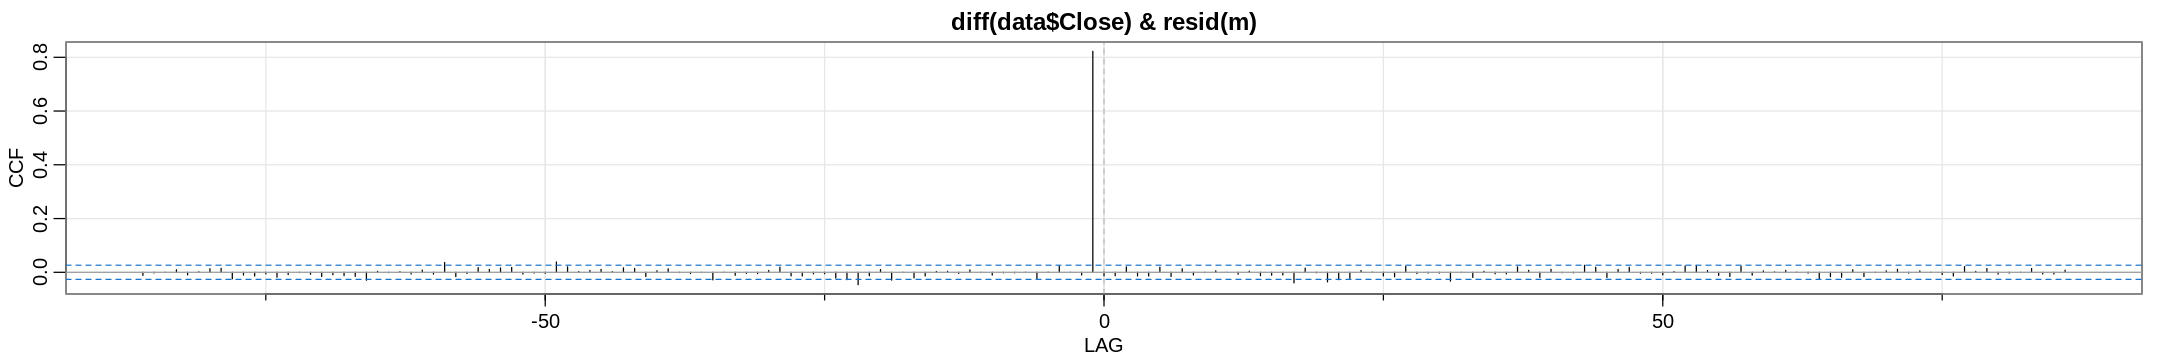

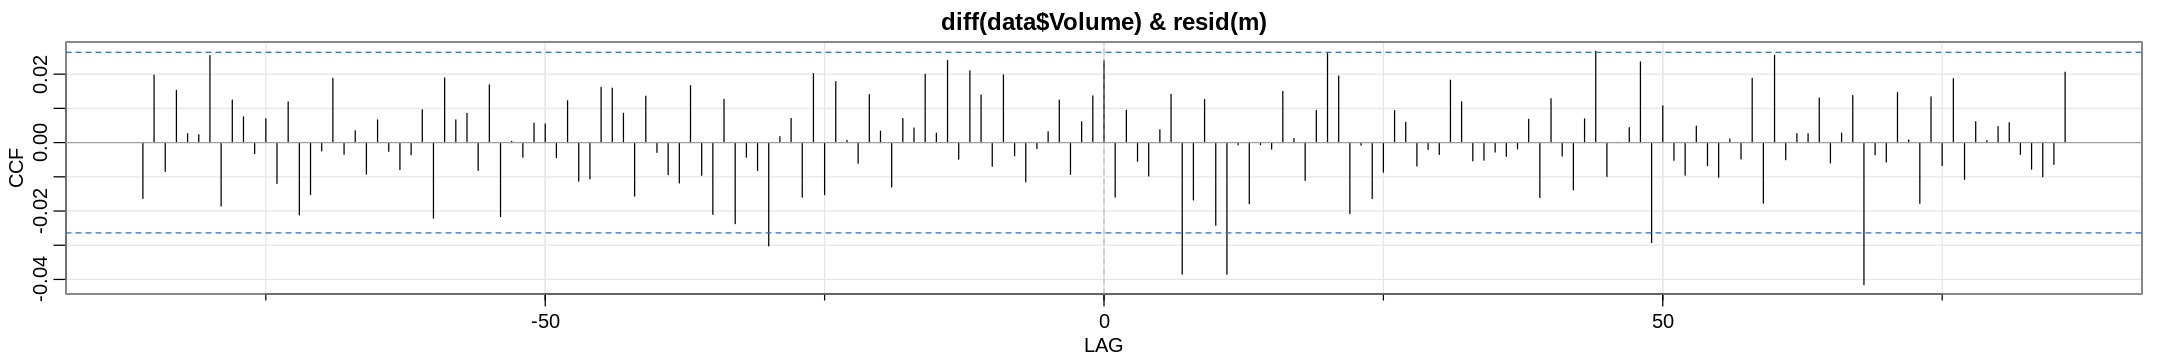

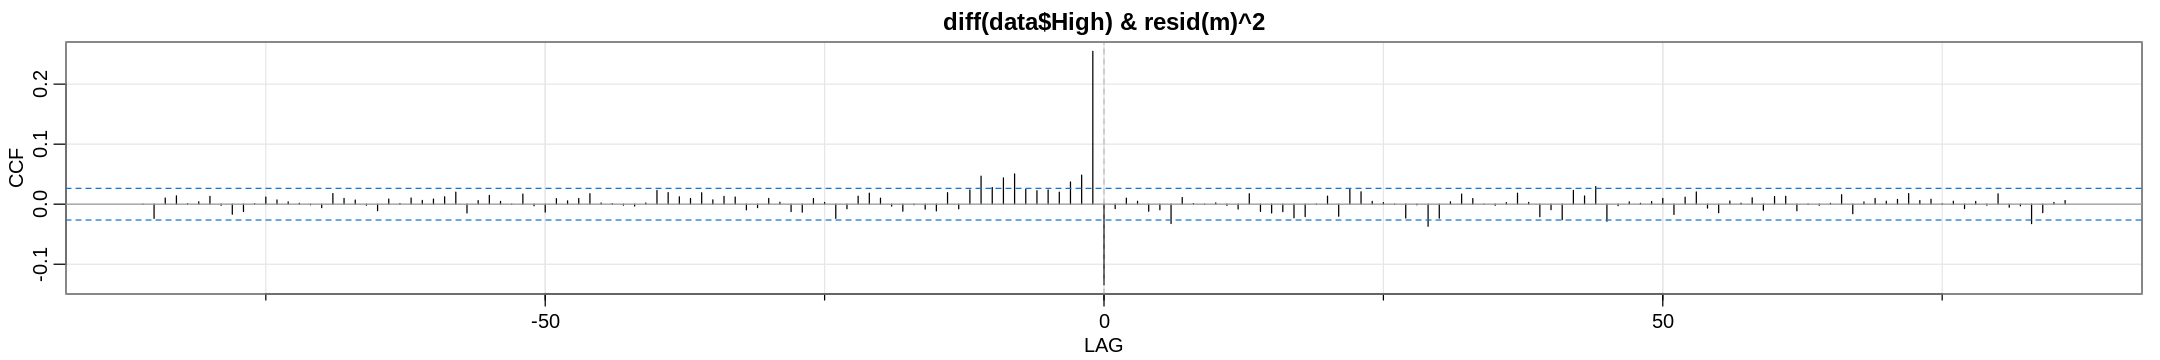

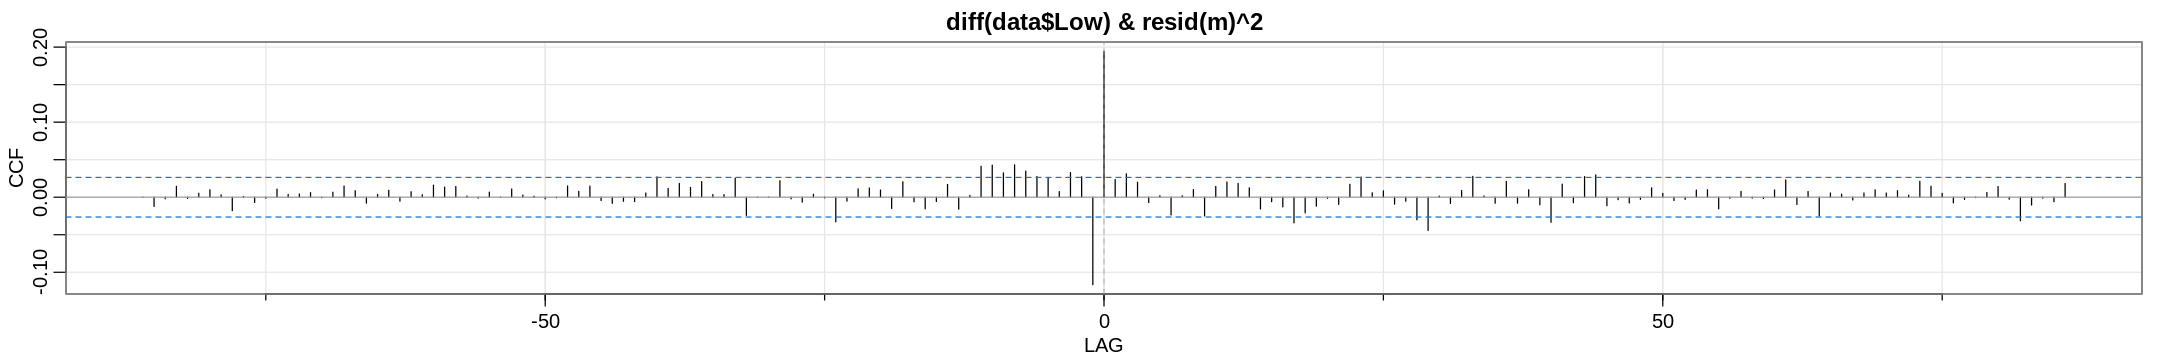

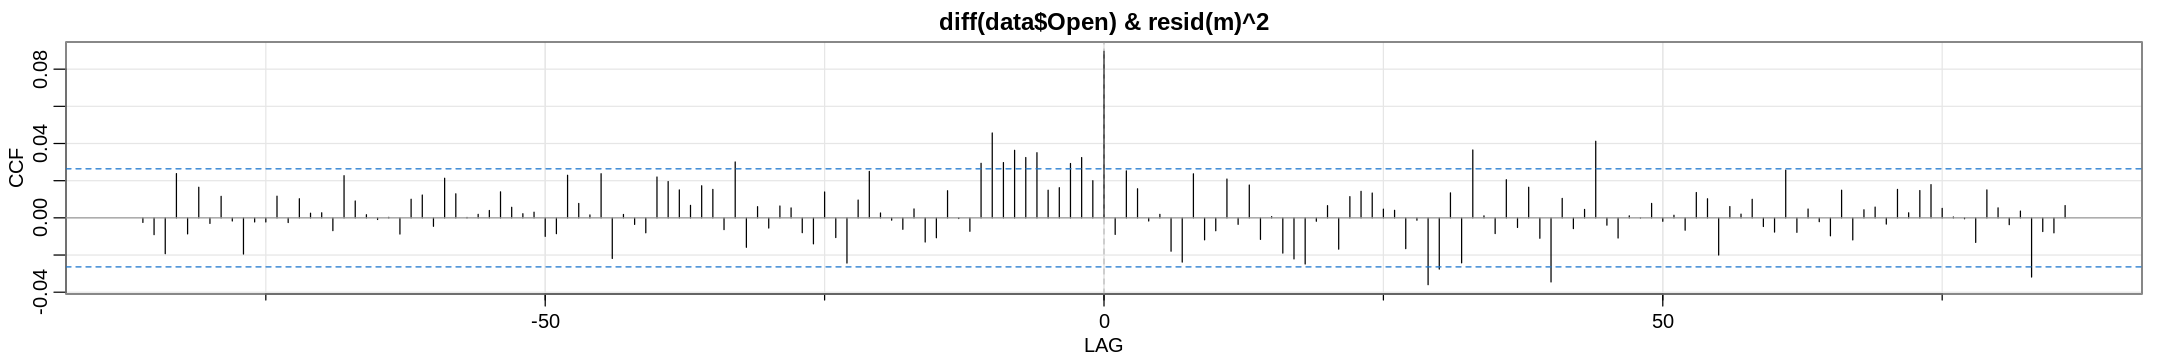

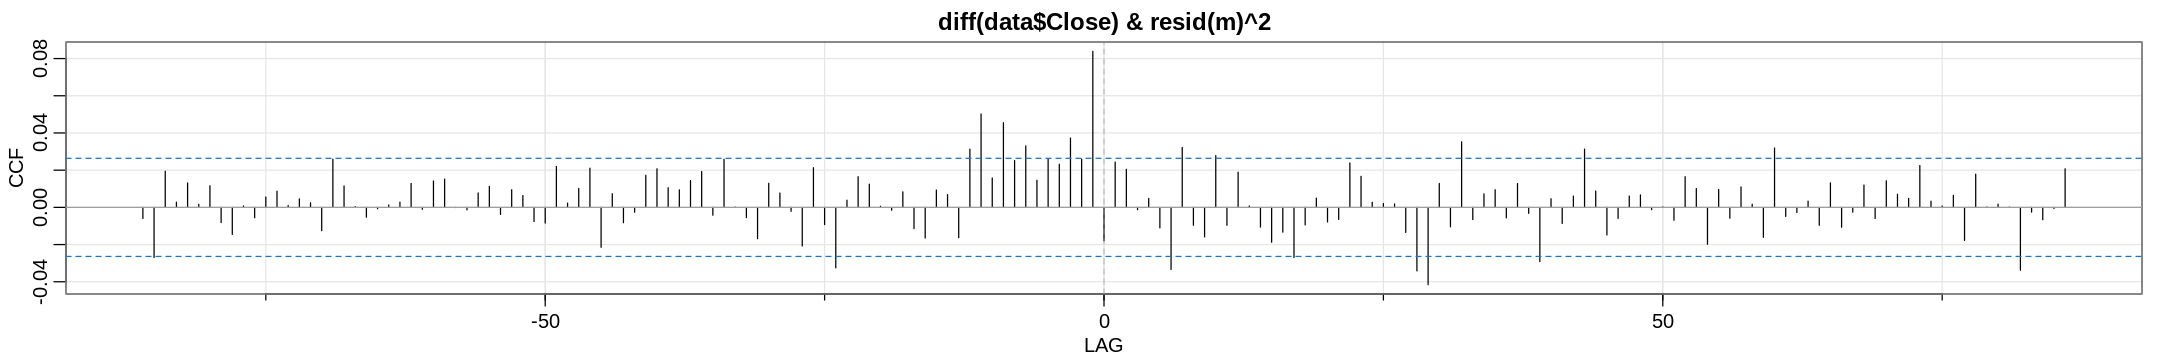

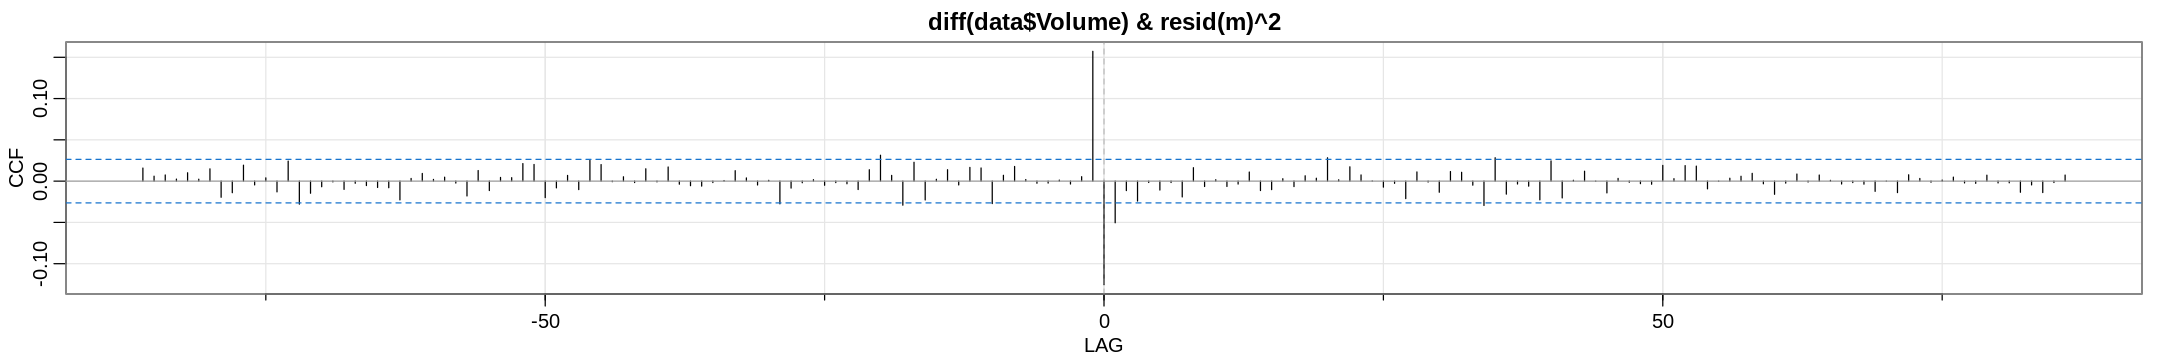

In [ ]:
options(repr.plot.width=18, repr.plot.height=3)

ccf2(data$High, resid(m))

ccf2(high.ts.gr, resid(m))
ccf2(data$Low, resid(m))

ccf2(diff(data$Low), resid(m))

ccf2(low.ts.gr, resid(m))
ccf2(data$Open, resid(m))
ccf2(open.ts.gr, resid(m))
ccf2(data$Close, resid(m))

ccf2(open.ts.gr, resid(m))
ccf2(data$Volume, resid(m))
ccf2(vol.ts.diff, resid(m))

ccf2(data$High, resid(m)^2)

ccf2(high.ts.gr, resid(m)^2)
ccf2(data$Low, resid(m)^2)
ccf2(low.ts.gr, resid(m)^2)
ccf2(data$Open, resid(m)^2)
ccf2(open.ts.gr, resid(m)^2)
ccf2(data$Close, resid(m)^2)

ccf2(open.ts.gr, resid(m)^2)
ccf2(data$Volume, resid(m)^2)
ccf2(vol.ts.diff, resid(m)^2)

ccf2(diff(data$High), resid(m))
ccf2(diff(data$Low), resid(m))
ccf2(diff(data$Open), resid(m))
ccf2(diff(data$Close), resid(m))
ccf2(diff(data$Volume), resid(m))


ccf2(diff(data$High), resid(m)^2)
ccf2(diff(data$Low), resid(m)^2)
ccf2(diff(data$Open), resid(m)^2)
ccf2(diff(data$Close), resid(m)^2)
ccf2(diff(data$Volume), resid(m)^2)


As an attempt to model some periodicity, we also analyzed the periodogram, but we didn't find that the spikes appeared meaningful. 

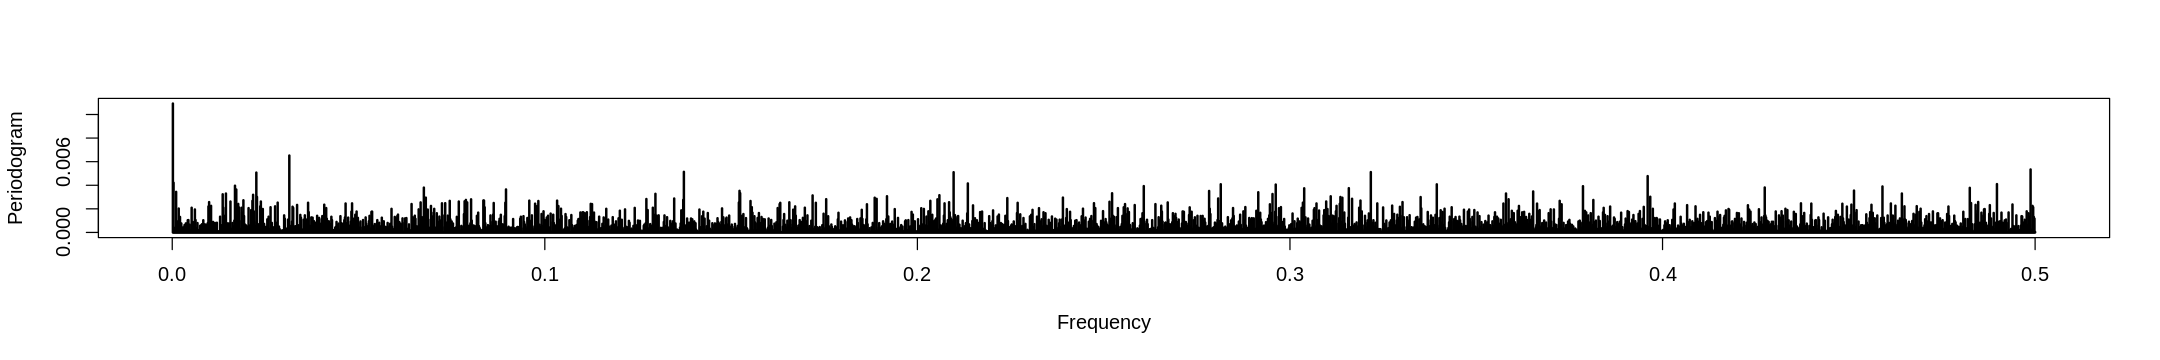

In [ ]:
periodogram(daily.return) #Periodgram was ran and created to try and find some patterns or seasonal behavior in the dataset

# Closing Remarks



Although we don't draw any strong conclusions on the best model for our data, we did learn a lot from conducting our analysis. Modeling financial data seems to be particularly difficult, but we did learn a lot about time series analysis and how to apply the techniques we studied in class and throughout the semester. 




